In [4]:
# IBL PP-Seq + Decoding Analysis
# Phase 1: Data Setup and Sequence Detection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# IBL Data Access Setup
from one.api import ONE
from iblatlas.regions import BrainRegions
print("✓ IBL libraries imported successfully")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

from ppseq.model import PPSeq
import torch.distributions as dist

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


✓ IBL libraries imported successfully


In [5]:
# Setup ONE API connection
print("Setting up IBL data connection...")
one = ONE(base_url='https://openalyx.internationalbrainlab.org')
one.load_cache(tag='Brainwidemap')
REVISION = '2024-05-06'
print(f"✓ Connected to IBL database (revision: {REVISION})")

# Initialize brain regions mapper
brain_regions = BrainRegions()
print("✓ Brain regions atlas loaded")

Setting up IBL data connection...
✓ Connected to IBL database (revision: 2024-05-06)
✓ Brain regions atlas loaded


In [6]:
def find_suitable_sessions(min_trials=400):
    """Find sessions suitable for PP-Seq analysis - SIMPLIFIED"""
    print("Searching for suitable sessions...")
    
    # Search for Brainwidemap sessions - these are high quality
    eids = one.search(tag='Brainwidemap')
    print(f"Found {len(eids)} Brainwidemap sessions")
    
    suitable_sessions = []
    
    for i, eid in enumerate(eids[:10]):  # Check first 10 sessions
        try:
            print(f"  Checking session {i+1}/10: {eid}")
            
            # Try to load the main objects - let IBL handle the complexity
            trials = one.load_object(eid, 'trials')
            spikes = one.load_object(eid, 'spikes')  
            clusters = one.load_object(eid, 'clusters')
            
            # Simple checks
            if trials is None or spikes is None or clusters is None:
                print(f"    Missing core data objects")
                continue
                
            if len(trials.get('stimOn_times', [])) < min_trials:
                print(f"    Only {len(trials.get('stimOn_times', []))} trials")
                continue
                
            if len(spikes.get('times', [])) < 1000:
                print(f"    Only {len(spikes.get('times', []))} spikes")
                continue
            
            # Success!
            suitable_sessions.append({
                'eid': eid,
                'n_trials': len(trials['stimOn_times']),
                'n_spikes': len(spikes['times'])
            })
            
            print(f"    ✓ Good session: {len(trials['stimOn_times'])} trials, {len(spikes['times']):,} spikes")
            
            if len(suitable_sessions) >= 1:  # Just get 1 good session
                break
                
        except Exception as e:
            print(f"    Error: {e}")
            continue
    
    return suitable_sessions


def load_session_data(eid):
    """Load comprehensive data for PP-Seq analysis"""
    print(f"Loading session data for {eid}...")
    
    # Load behavioral data
    print("  Loading behavioral data...")
    trials = one.load_object(eid, 'trials', revision=REVISION)
    
    # Load neural data
    print("  Loading neural data...")
    spikes = one.load_object(eid, 'spikes', revision=REVISION)
    clusters = one.load_object(eid, 'clusters', revision=REVISION)
    
    # Load brain location data
    print("  Loading brain location data...")
    channels = one.load_object(eid, 'channels', revision=REVISION)
    
    # Load probe information
    print("  Loading probe information...")
    probes = one.load_object(eid, 'probes', revision=REVISION)
    
    return {
        'eid': eid,
        'trials': trials,
        'spikes': spikes, 
        'clusters': clusters,
        'channels': channels,
        'probes': probes
    }

def explore_session_data(data):
    """Explore the loaded data"""
    trials = data['trials']
    spikes = data['spikes']
    clusters = data['clusters']
    
    print("=== SESSION OVERVIEW ===")
    print(f"Session duration: {spikes['times'][-1]:.1f} seconds")
    print(f"Total trials: {len(trials['stimOn_times'])}")
    print(f"Total spikes: {len(spikes['times']):,}")
    print(f"Total clusters: {len(clusters['channels'])}")
    
    # Behavioral summary
    print("\n=== BEHAVIORAL SUMMARY ===")
    correct_trials = trials['feedbackType'] == 1
    print(f"Performance: {np.mean(correct_trials)*100:.1f}% correct")
    
    # Check stimulus contrasts
    contrasts = np.unique(trials['contrastLeft'][~np.isnan(trials['contrastLeft'])])
    contrasts = np.concatenate([contrasts, np.unique(trials['contrastRight'][~np.isnan(trials['contrastRight'])])])
    print(f"Stimulus contrasts: {np.unique(contrasts)}")
    
    # Neural summary  
    print("\n=== NEURAL SUMMARY ===")
    print(f"Spike rate: {len(spikes['times'])/spikes['times'][-1]:.1f} Hz (all units)")
    
    # Get brain regions if available
    if 'brainLocationIds_ccf_2017' in clusters:
        brain_location_ids = clusters['brainLocationIds_ccf_2017']
        unique_regions = []
        for loc_id in np.unique(brain_location_ids):
            if not np.isnan(loc_id):
                region_info = brain_regions.get(int(loc_id))
                if region_info:
                    unique_regions.append(region_info.acronym)
        
        print(f"Brain regions recorded: {len(unique_regions)}")
        print(f"Top regions: {unique_regions[:10]}")
    
    return True

In [8]:


# Find sessions
sessions = find_suitable_sessions()
print(f"\n✓ Found {len(sessions)} suitable sessions")

# Select the first good session
if sessions:
    session = sessions[0]
    eid = session['eid']
    print(f"Selected session: {eid}")
    print(f"  - Trials: {session['n_trials']}")
    print(f"  - Spikes: {session['n_spikes']}")
else:
    print("❌ No suitable sessions found")


# Load the selected session
data = load_session_data(eid)
print("✓ Session data loaded successfully")


# Explore the data
explore_session_data(data)


Searching for suitable sessions...
Found 480 Brainwidemap sessions
  Checking session 1/10: adf19ea1-aa1e-4e0a-ab8b-59be2dfaeebe
    Error: trials 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
  Checking session 2/10: ebce500b-c530-47de-8cb1-963c552703ea


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.49it/s]


    ✓ Good session: 569 trials, 80,867,860 spikes

✓ Found 1 suitable sessions
Selected session: ebce500b-c530-47de-8cb1-963c552703ea
  - Trials: 569
  - Spikes: 80867860
Loading session data for ebce500b-c530-47de-8cb1-963c552703ea...
  Loading behavioral data...
  Loading neural data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3.0 [00:00<00:00,  3.50it/s]


  Loading brain location data...
  Loading probe information...
✓ Session data loaded successfully


In [1090]:
#%% Prepare Data for PP-Seq Analysis
def prepare_ppseq_data(data, time_window=None):
    """
    Prepare data for PP-Seq analysis following the analysis plan:
    - Extract spike times from ALL recorded regions  
    - Mark each spike: (time, neuron_id, brain_region, depth)
    - Timeline: [-500ms, +2000ms] relative to stimulus onset
    """
    print("Preparing data for PP-Seq analysis...")
    
    trials = data['trials']
    spikes = data['spikes']
    clusters = data['clusters']
    channels = data['channels']
    
    # Debug: Check what we actually have
    print(f"Spikes keys: {list(spikes.keys()) if spikes else 'None'}")
    print(f"Clusters keys: {list(clusters.keys()) if clusters else 'None'}")
    print(f"Channels keys: {list(channels.keys()) if channels else 'None'}")
    print(f"Trials keys: {list(trials.keys()) if trials else 'None'}")
    
    if spikes and 'times' in spikes:
        print(f"Number of spikes: {len(spikes['times'])}")
    else:
        print("No spike times found!")
    
    # Map clusters to brain regions
    print("Mapping clusters to brain regions...")
    cluster_to_region = {}
    
    if clusters and channels and 'channels' in clusters and 'brainLocationIds_ccf_2017' in channels:
        clusters_channels = clusters['channels']
        channels_loc_ids = channels['brainLocationIds_ccf_2017']
        
        for i, channel_idx in enumerate(clusters_channels):
            if channel_idx < len(channels_loc_ids):
                loc_id = channels_loc_ids[channel_idx]
                if isinstance(loc_id, np.ndarray):
                    loc_id = loc_id[-1]  # Take last ID if multiple
                
                region_info = brain_regions.get(loc_id)
                region_acronym = region_info.acronym if region_info else 'unknown'
                cluster_to_region[i] = region_acronym
            else:
                cluster_to_region[i] = 'unknown'
        
        print(f"✓ Mapped {len(cluster_to_region)} clusters to brain regions")
    else:
        print("⚠️ Brain location data not available, using 'unknown'")
    
    # Simple trial processing
    trial_df = pd.DataFrame({
        'trial_idx': range(len(trials['stimOn_times'])),
        'stim_time': trials['stimOn_times'],
        'movement_time': trials['firstMovement_times'],
        'choice': trials['choice'],
        'feedback_time': trials['feedback_times'],
        'feedbackType':  trials['feedbackType']
    })
    
    # Spike processing with brain region and depth mapping
    if spikes and 'times' in spikes and len(spikes['times']) > 0:
        # Map each spike to its brain region using cluster_to_region
        spike_regions = [cluster_to_region.get(cluster_id, 'unknown') 
                        for cluster_id in spikes['clusters']]
        
        # Create spike dataframe with depth information
        spike_df = pd.DataFrame({
            'time': spikes['times'],
            'neuron_id': spikes['clusters'],
            'brain_region': spike_regions,
            'depth': spikes['depths']  # Add depth information directly
        })
        
        print(f"✓ Depth range: {spike_df['depth'].min():.1f} to {spike_df['depth'].max():.1f} µm")
    else:
        spike_df = pd.DataFrame(columns=['time', 'neuron_id', 'brain_region', 'depth'])
    
    print(f"✓ Prepared {len(spike_df)} spikes, {len(trial_df)} trials")
    
    return {
        'trials': trial_df,
        'spikes': spike_df,
        'session_info': {
            'eid': data['eid'],
            'duration': spikes['times'][-1] if spikes and 'times' in spikes else 0,
            'n_neurons': len(np.unique(spikes['clusters'])) if spikes and 'clusters' in spikes else 0
        }
    }

# Prepare data for analysis
analysis_data = prepare_ppseq_data(data)

#%% Summary and Next Steps
print("\n" + "="*50)
print("IBL PP-SEQ ANALYSIS SETUP COMPLETE")
print("="*50)

session_info = analysis_data['session_info']
trials_df = analysis_data['trials']
spikes_df = analysis_data['spikes']

print(f"Session: {session_info['eid']}")
print(f"Duration: {session_info['duration']:.1f} seconds")
print(f"Neurons: {session_info['n_neurons']}")
print(f"Valid trials: {len(trials_df)}")
print(f"Total spikes: {len(spikes_df):,}")
print(f"Brain regions: {spikes_df['brain_region'].nunique()}")

# Show region breakdown
print(f"\nTop brain regions by spike count:")
region_counts = spikes_df['brain_region'].value_counts().head(10)
for region, count in region_counts.items():
    print(f"  {region}: {count:,} spikes")

# Show depth information
print(f"\nDepth information:")
print(f"  Depth range: {spikes_df['depth'].min():.1f} to {spikes_df['depth'].max():.1f} µm")
print(f"  Mean depth: {spikes_df['depth'].mean():.1f} µm")

# Simple trial breakdown using available columns
print(f"\nTrial breakdown:")
print(f"  Total trials: {len(trials_df)}")
print(f"  Choices: {np.sum(trials_df['choice'] == 1)} right, {np.sum(trials_df['choice'] == -1)} left")

Preparing data for PP-Seq analysis...
Spikes keys: ['amps', 'clusters', 'depths', 'samples', 'templates', 'times']
Clusters keys: ['amps', 'channels', 'depths', 'metrics', 'peakToTrough', 'uuids', 'waveforms', 'waveformsChannels']
Channels keys: ['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd']
Trials keys: ['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft', 'contrastRight', 'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume', 'firstMovement_times', 'intervals']
Number of spikes: 80867860
Mapping clusters to brain regions...
✓ Mapped 1557 clusters to brain regions
✓ Depth range: 20.0 to 3828.9 µm
✓ Prepared 80867860 spikes, 569 trials

IBL PP-SEQ ANALYSIS SETUP COMPLETE
Session: ebce500b-c530-47de-8cb1-963c552703ea
Duration: 7200.2 seconds
Neurons: 1557
Valid trials: 569
Total spikes: 80,867,860
Brain regions: 16

Top brain regions by spike count:
  PO: 59,162,827 spikes
  LP: 8

In [1092]:
def extract_trial_windows_with_flat_data(
    analysis_data, 
    window_ms=[-500, 2000], 
    bin_ms=5, 
    iti_window_ms=[-1000, 0],  # Additional window before stimulus onset
    post_feedback_ms=500  # Window after feedback
):
    """
    Enhanced trial window extraction with flat data concatenation and additional metadata
    
    Returns:
    --------
    tuple containing:
    - trial_windows : np.ndarray
        Original trial windows (trials, neurons, bins)
    - flat_data : np.ndarray
        Concatenated data across all trials (neurons, total_bins)
    - trial_labels : list
        Labels for each trial
    - unique_neurons : np.ndarray
        Unique neuron IDs
    - units_df : pd.DataFrame
        DataFrame with one row per neuron containing depth, brain_region, etc.
    - metadata : dict
        Additional trial and time metadata
    """
    from tqdm import tqdm
    import numpy as np
    import pandas as pd
    
    print("🚀 Extracting trial windows with flat data...")
    
    trials_df = analysis_data['trials']
    spikes_df = analysis_data['spikes']
    
    # Filter valid trials
    valid_mask = (
        (~np.isnan(trials_df['movement_time'])) &
        (~np.isnan(trials_df['feedback_time'])) &
        (trials_df['movement_time'] - trials_df['stim_time'] >= 0.08)
    )
    valid_trials = trials_df[valid_mask].copy().reset_index(drop=True)
    print(f"Valid trials: {len(valid_trials)}/{len(trials_df)}")
    
    # Setup - vectorize neuron mapping
    spike_times = spikes_df['time'].values
    spike_neurons = spikes_df['neuron_id'].values
    spike_depths = spikes_df['depth'].values  # Extract depths
    spike_regions = spikes_df['brain_region'].values  # Extract regions
    
    unique_neurons = np.unique(spike_neurons)
    n_neurons = len(unique_neurons)
    
    # ===== CREATE UNITS DATAFRAME =====
    print("Creating units DataFrame...")
    
    # For each unique neuron, get its depth and brain region (take first occurrence)
    units_data = []
    for i, neuron_id in enumerate(unique_neurons):
        # Find first occurrence of this neuron
        first_idx = np.where(spike_neurons == neuron_id)[0][0]
        
        units_data.append({
            'neuron_idx': i,  # Index in unique_neurons array
            'neuron_id': neuron_id,  # Original neuron ID
            'depth': spike_depths[first_idx],
            'brain_region': spike_regions[first_idx]
        })
    
    units_df = pd.DataFrame(units_data)
    print(f"✓ Created units DataFrame: {len(units_df)} neurons")
    print(f"  Depth range: {units_df['depth'].min():.1f} to {units_df['depth'].max():.1f}")
    print(f"  Brain regions: {units_df['brain_region'].nunique()} unique regions")
    
    # Create vectorized neuron mapping
    max_neuron_id = unique_neurons.max()
    neuron_idx_map = np.full(max_neuron_id + 1, -1, dtype=int)
    neuron_idx_map[unique_neurons] = np.arange(n_neurons)
    
    # ===== WINDOW CALCULATION (same as before) =====
    
    # Calculate full window duration from earliest to latest time point
    full_window_start_ms = min(iti_window_ms[0], window_ms[0])  # Earlier of ITI or stim window start
    full_window_end_ms = max(window_ms[1], post_feedback_ms)    # Later of stim window end or post-feedback
    
    full_window_duration_ms = full_window_end_ms - full_window_start_ms
    n_bins = int(np.ceil(full_window_duration_ms / bin_ms))
    
    print(f"Processing {len(valid_trials)} trials, {n_neurons} neurons")
    print(f"Full window: {full_window_start_ms}ms to {full_window_end_ms}ms = {full_window_duration_ms}ms total")
    print(f"Bin size: {bin_ms}ms, Total bins per trial: {n_bins}")
    
    # Pre-allocate arrays
    trial_windows = np.zeros((len(valid_trials), n_neurons, n_bins))
    flat_data = np.zeros((n_neurons, n_bins * len(valid_trials)))
    
    # Metadata tracking
    trial_labels = []
    iti_start_indices = []
    trial_start_indices = []
    feedback_indices = []
    trial_end_indices = []
    
    # Extract arrays for faster access
    stim_times = valid_trials['stim_time'].values
    movement_times = valid_trials['movement_time'].values
    feedback_trial_times = valid_trials['feedback_time'].values
    choices = valid_trials['choice'].values
    trial_indices = valid_trials.index.values
    
    for i, (stim_time, movement_time, feedback_time, choice, trial_idx) in tqdm(enumerate(
        zip(stim_times, movement_times, feedback_trial_times, choices, trial_indices))
    ):
        # ===== TIME WINDOW CALCULATION =====
        
        # Calculate absolute time points
        absolute_window_start = stim_time + full_window_start_ms/1000  # Convert ms to seconds
        iti_start_time = stim_time + iti_window_ms[0]/1000             # ITI start time
        stim_start_time = stim_time + window_ms[0]/1000                # Stimulus window start
        feedback_end_time = feedback_time + post_feedback_ms/1000      # Post-feedback end
        
        # Determine window end time (whichever comes last)
        stim_end_time = stim_time + window_ms[1]/1000
        absolute_window_end = max(stim_end_time, feedback_end_time)
        
        # Calculate bin indices for important time points
        # All relative to the absolute_window_start time
        iti_start_bin = int((iti_start_time - absolute_window_start) * 1000 // bin_ms)
        stim_start_bin = int((stim_start_time - absolute_window_start) * 1000 // bin_ms)
        stim_onset_bin = int((stim_time - absolute_window_start) * 1000 // bin_ms)
        feedback_bin = int((feedback_time - absolute_window_start) * 1000 // bin_ms)
        window_end_bin = int((absolute_window_end - absolute_window_start) * 1000 // bin_ms)
        
        # Store bin indices for later reference
        trial_start_idx = i * n_bins
        iti_start_indices.append(trial_start_idx + iti_start_bin)
        trial_start_indices.append(trial_start_idx + stim_onset_bin)
        feedback_indices.append(trial_start_idx + feedback_bin)
        trial_end_indices.append(trial_start_idx + window_end_bin)
        
        # ===== SPIKE EXTRACTION =====
        
        # Get spikes in the full time window
        in_window = (spike_times >= absolute_window_start) & (spike_times < absolute_window_end)
        
        if np.any(in_window):
            # Extract relative spike times (seconds relative to window start)
            rel_spike_times = spike_times[in_window] - absolute_window_start
            spike_neuron_ids = spike_neurons[in_window]
            
            # Convert to ms and calculate bin indices
            spike_times_ms = rel_spike_times * 1000
            bin_indices = (spike_times_ms // bin_ms).astype(int)
            
            # Filter valid bins and neurons
            valid_bins = (bin_indices >= 0) & (bin_indices < n_bins)
            valid_neurons = (spike_neuron_ids <= max_neuron_id) & (neuron_idx_map[spike_neuron_ids] >= 0)
            valid_mask = valid_bins & valid_neurons
            
            if np.any(valid_mask):
                # Get final indices
                final_bins = bin_indices[valid_mask]
                neuron_indices = neuron_idx_map[spike_neuron_ids[valid_mask]]
                
                # Add spikes to trial window
                window_spike_matrix = np.zeros((n_neurons, n_bins))
                np.add.at(window_spike_matrix, (neuron_indices, final_bins), 1)
                trial_windows[i] = window_spike_matrix
                
                # Add to flat data
                flat_start = i * n_bins
                flat_end = (i + 1) * n_bins
                flat_data[:, flat_start:flat_end] = window_spike_matrix
        
        # Store trial labels
        trial_labels.append({
            'trial_idx': trial_idx,
            'choice': 'left' if choice == -1 else 'right',
            'reaction_time': movement_time - stim_time,
            'stim_time': stim_time,
            'feedback_time': feedback_time
        })
    
    # Metadata dictionary
    metadata = {
        'iti_start_indices': np.array(iti_start_indices),
        'trial_start_indices': np.array(trial_start_indices),
        'feedback_indices': np.array(feedback_indices),
        'trial_end_indices': np.array(trial_end_indices),
        'bin_ms': bin_ms,
        'iti_window_ms': iti_window_ms,
        'stim_window_ms': window_ms,
        'post_feedback_ms': post_feedback_ms,
        'full_window_start_ms': full_window_start_ms,
        'full_window_end_ms': full_window_end_ms,
        'full_window_duration_ms': full_window_duration_ms,
        'n_bins_per_trial': n_bins
    }
    
    print(f"✓ Complete: {trial_windows.shape}, {flat_data.shape}")
    
    return trial_windows, flat_data, trial_labels, unique_neurons, units_df, metadata

# Updated function call
trial_windows, flat_data, trial_labels, unique_neurons, units_df, metadata = extract_trial_windows_with_flat_data(
    analysis_data,
    window_ms=[-500, 2000],  # default
    bin_ms=10,                # default
    iti_window_ms=[-1000, 0],  # Optional: customize pre-stimulus window
    post_feedback_ms=500     # Optional: customize post-feedback window
)

# Now you have a clean units DataFrame for easy access
print(f"\nUnits DataFrame:")
print(units_df.head())
print(f"\nBrain regions: {units_df['brain_region'].value_counts()}")

🚀 Extracting trial windows with flat data...
Valid trials: 512/569
Creating units DataFrame...
✓ Created units DataFrame: 1557 neurons
  Depth range: 50.4 to 3788.1
  Brain regions: 16 unique regions
Processing 512 trials, 1557 neurons
Full window: -1000ms to 2000ms = 3000ms total
Bin size: 10ms, Total bins per trial: 300


512it [01:35,  5.39it/s]

✓ Complete: (512, 1557, 300), (1557, 153600)

Units DataFrame:
   neuron_idx  neuron_id       depth brain_region
0           0          0   95.283173           PO
1           1          1  198.217880           PO
2           2          2  108.161812           PO
3           3          3   50.385029           PO
4           4          4  164.335175           PO

Brain regions: brain_region
PO           1014
LP            133
CA1            93
SSp-tr6a       73
SSp-tr5        59
SSp-tr4        59
CA3            54
DG-mo          31
or             12
scwm            9
SSp-tr6b        8
ccs             4
DG-sg           3
alv             3
root            1
SSp-tr2/3       1
Name: count, dtype: int64


In [1093]:
def select_trials_from_flat_data(
    flat_data, 
    trial_labels, 
    selected_trial_ids, 
    n_bins_per_trial
):
    """
    Extract specific trials from flat data based on original trial IDs
    
    Parameters:
    -----------
    flat_data : np.ndarray
        Concatenated spike data (neurons, total_bins)
    trial_labels : list
        List of trial label dictionaries
    selected_trial_ids : np.ndarray
        Array of original trial IDs to extract
    n_bins_per_trial : int
        Number of bins per trial
    
    Returns:
    --------
    flat_data_selected : np.ndarray
        Selected trial data (neurons, selected_trials * bins_per_trial)
    selected_labels : list
        Labels for selected trials
    selected_indices : np.ndarray
        Indices of selected trials in the original dataset
    """
    # Find indices of selected trials
    selected_indices = []
    selected_subset_labels = []
    
    for i, label in enumerate(trial_labels):
        if label['trial_idx'] in selected_trial_ids:
            selected_indices.append(i)
            selected_subset_labels.append(label)

    # Sort indices based on the order of selected_trial_ids
    sorted_indices = sorted(
        selected_indices, 
        key=lambda idx: np.where(selected_trial_ids == trial_labels[idx]['trial_idx'])[0][0]
    )
    
    # Extract data for selected trials
    flat_data_selected = np.concatenate([
        flat_data[:, idx*n_bins_per_trial:(idx+1)*n_bins_per_trial] 
        for idx in sorted_indices
    ], axis=1)
    
    # Reorder labels to match sorted data
    selected_labels = [trial_labels[idx] for idx in sorted_indices]
    
    return flat_data_selected, selected_labels, np.array(sorted_indices)

# Number of bins per trial
n_bins_per_trial = flat_data.shape[1] // len(trial_labels)

# Define your trials of interest
osc_trials = np.array([487, 486, 483, 478, 476, 473, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470])

# Extract selected trials
flat_data_selected, selected_labels, selected_indices = select_trials_from_flat_data(
    flat_data, 
    trial_labels, 
    osc_trials, 
    n_bins_per_trial
)



In [1094]:
def plot_raster_from_flat_data(
    flat_data_selected, 
    n_bins_per_trial,
    bin_ms=5,
    time_window_ms=[-500, 2000],
    start_bin=None,
    end_bin=None
):
    """
    Create a raster plot from selected flat data
    
    Parameters:
    -----------
    flat_data_selected : np.ndarray
        Selected trial data (neurons, total_selected_bins)
    n_bins_per_trial : int
        Number of bins per trial
    bin_ms : int, optional
        Bin size in milliseconds (default: 5)
    time_window_ms : list, optional
        Time window for plotting (default: [-500, 2000])
    start_bin : int, optional
        Starting bin for visualization (default: None, start of data)
    end_bin : int, optional
        Ending bin for visualization (default: None, end of data)
    
    Returns:
    --------
    matplotlib.figure.Figure
        Raster plot figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Number of selected trials
    n_trials = flat_data_selected.shape[1] // n_bins_per_trial
    
    # Define start and end bins
    if start_bin is None:
        start_bin = 0
    if end_bin is None:
        end_bin = flat_data_selected.shape[1]
    
    # Slice the data
    flat_data_subset = flat_data_selected[:, start_bin:end_bin]
    
    # Prepare spike coordinates
    spike_coords = np.where(flat_data_subset > 0)
    
    # Adjust x-coordinates to account for start_bin
    spike_coords_adjusted = (spike_coords[0], spike_coords[1] + start_bin)
    
    # Create figure
    plt.figure(figsize=(15, 8))
    plt.scatter(
        spike_coords_adjusted[1], 
        spike_coords_adjusted[0], 
        s=2, 
        alpha=0.7, 
        color='black'
    )
    
    # Add trial boundaries
    for i in range(1, n_trials):
        trial_start = i * n_bins_per_trial
        if start_bin <= trial_start < end_bin:
            plt.axvline(
                trial_start, 
                color='red', 
                linestyle='--', 
                alpha=0.5
            )
    
    # Calculate time labels
    start_time_ms = start_bin * bin_ms
    end_time_ms = end_bin * bin_ms
    
    plt.xlim(start_bin, end_bin)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons')
    plt.title(f'Raster Plot ({start_time_ms} to {end_time_ms} ms)')
    plt.tight_layout()
    
    return plt.gcf()

# fig = plot_raster_from_flat_data(
#     flat_data, 
#     n_bins_per_trial,
#     bin_ms=5,
#     time_window_ms=[-500, 2000],
#     start_bin=277750,  # Start at 500ms 
#     end_bin=278750     # End at 1000ms
# )
# plt.show()



In [1095]:
flat_data_selected.shape

(1557, 5100)

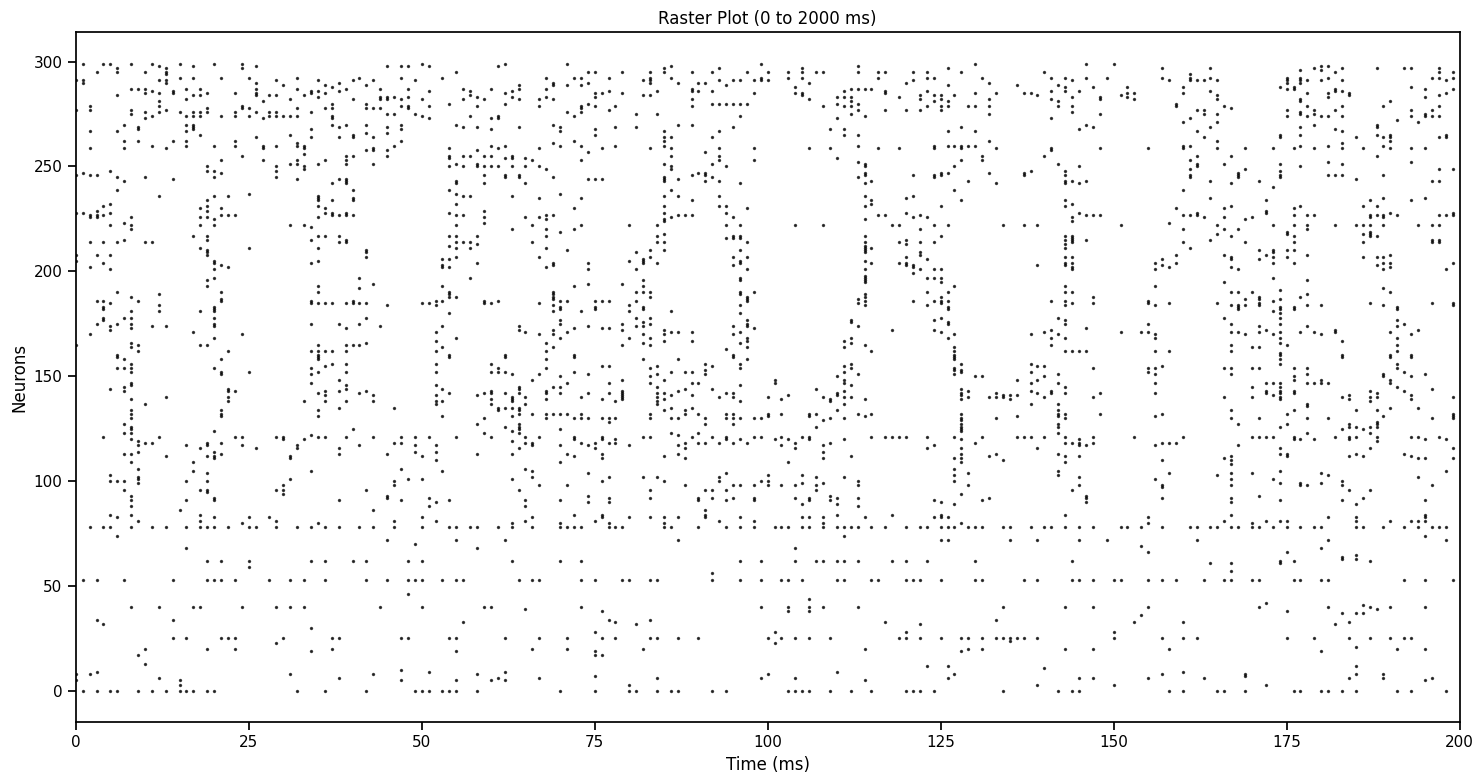

3000

In [1096]:
osc_trials = np.array([487, 478, 476, 473, 460, 462, 463, 464, 465, 466, 467, 468, 469, 470])
osc_trials =  np.array([407, 408, 411]) #, 434, 454, 457, 463, 467, 468, 469, 553, 546, 540, 538, 537, 533, ])
osc_trials =  np.array([407, 408, 411 , 434, 454, 457, 463, 467, 468, 469, 553, 546, 540, 538, 537, 533, ])

# Extract selected trials
flat_data_selected, selected_labels, selected_indices = select_trials_from_flat_data(
    flat_data, 
    trial_labels, 
    osc_trials, 
    n_bins_per_trial
)

fig = plot_raster_from_flat_data(
    flat_data_selected[600:900], 
    n_bins_per_trial,
    bin_ms=10,
    time_window_ms=[-500, 2000],
    start_bin=0,  # Start at 500ms 
    end_bin=200     # End at 1000ms
)
plt.show()

len(flat_data_selected[0])


In [1097]:
analysis_data.keys()

dict_keys(['trials', 'spikes', 'session_info'])

FITTING PP-SEQ MODEL
Configuring PP-Seq with 4 sequence templates...
PP-Seq Configuration:
  num_templates: 4
  template_duration: 10
  alpha_a0: 2.2
  beta_a0: 0.2
  alpha_b0: 1
  beta_b0: 0.1
  alpha_t0: 0.1
  beta_t0: 0.03

Fitting PP-Seq model...
Training PP-Seq (this may take a few minutes)...


✓ PP-Seq training complete!
Neuron depths range: 358.7 to 1439.1
Subset neuron info:
  Count: 300
  Depth range: 358.7 to 1439.1 µm
  Mean depth: 837.4 µm
  Brain regions in subset: brain_region
PO    248
LP     52
Name: count, dtype: int64


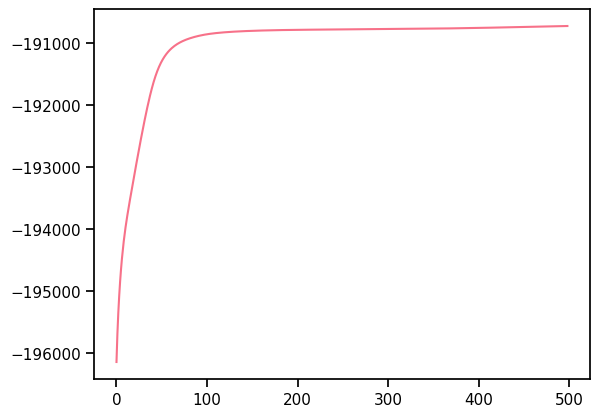

In [1107]:
#%% PP-Seq Model Configuration and Training
import importlib 
import ppseq.model
importlib.reload(ppseq.model)
from ppseq.model import PPSeq

def get_neuron_depths_from_units(units_df, neuron_indices_subset):
    """
    Get depths for specific neuron indices subset using units_df
    """
    # Much simpler - just slice the units_df by neuron indices
    subset_depths = units_df.iloc[neuron_indices_subset]['depth'].values
    return subset_depths

def configure_and_fit_ppseq(flat_data, units_df, neuron_indices_subset, num_templates=12):
    """
    Configure and fit PP-Seq model with depth information
    """
    print(f"Configuring PP-Seq with {num_templates} sequence templates...")
    n_neurons = flat_data.shape[0]
    
    # Get depth information for this neuron subset
    neuron_depths = get_neuron_depths_from_units(units_df, neuron_indices_subset)
    
    # Convert to torch tensor
    torch_data = torch.from_numpy(flat_data).float().to('cuda')
    
    # Configure PP-Seq model parameters
    ppseq_config = {
        'num_templates': num_templates,
        'template_duration': 10,
        'alpha_a0': 2.2,
        'beta_a0': 0.2,
        'alpha_b0': 1,
        'beta_b0': 0.1,
        'alpha_t0': .1,
        'beta_t0': 0.03
    }
    
    print("PP-Seq Configuration:")
    for key, value in ppseq_config.items():
        print(f"  {key}: {value}")
    
    # Create and fit PP-Seq model
    print("\nFitting PP-Seq model...")
    model = PPSeq(
        num_neurons=n_neurons,
        device=device,
        **ppseq_config,
    )
    
    # Fit model
    print("Training PP-Seq (this may take a few minutes)...")
    log_likelihoods, amplitudes = model.fit(torch_data, num_iter=500)
    
    print("✓ PP-Seq training complete!")
    
    return model, amplitudes, log_likelihoods, torch_data, neuron_depths

# Fit PP-Seq model
print("="*50)
print("FITTING PP-SEQ MODEL")
print("="*50)

neuron_indices_subset = slice(600, 900)  # Store the indices you're using
model, amplitudes, log_likelihoods, torch_data, neuron_depths = configure_and_fit_ppseq(
    flat_data_selected[600:900, 0:3000],  # Fixed: removed _selected 
    units_df,  # Use units_df instead of analysis_data and unique_neurons
    neuron_indices_subset,
    num_templates=4
)

plt.plot(log_likelihoods.cpu().numpy()[1:])
print(f"Neuron depths range: {neuron_depths.min():.1f} to {neuron_depths.max():.1f}")

# Show some depth statistics for the subset
print(f"Subset neuron info:")
print(f"  Count: {len(neuron_depths)}")
print(f"  Depth range: {neuron_depths.min():.1f} to {neuron_depths.max():.1f} µm")
print(f"  Mean depth: {neuron_depths.mean():.1f} µm")
print(f"  Brain regions in subset: {units_df.iloc[neuron_indices_subset]['brain_region'].value_counts()}")

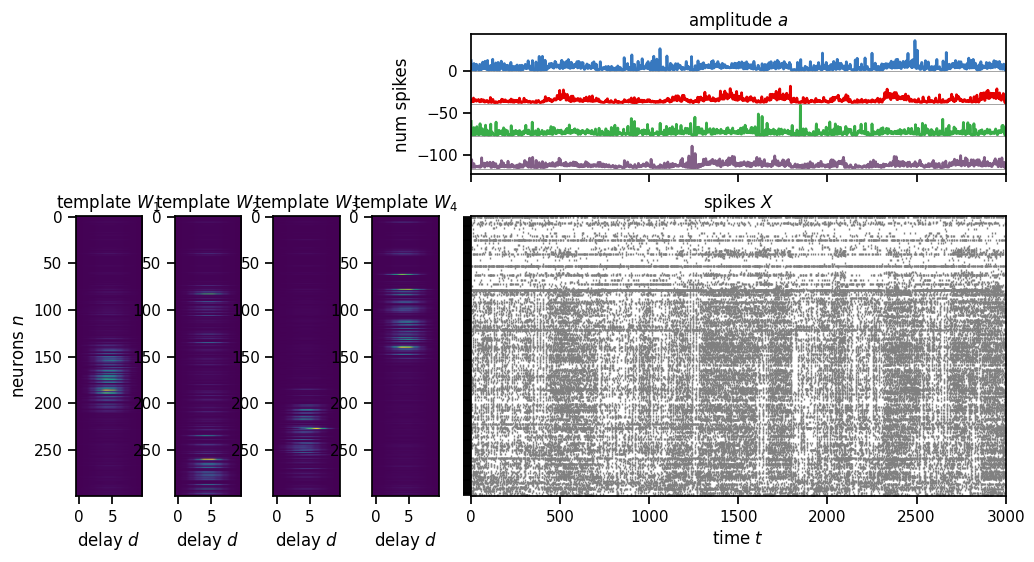

In [1108]:
fig_model = plot_model(model.templates.cpu(), amplitudes.cpu(), torch_data.cpu())

In [1109]:
# from ppseq.plotting import plot_model, color_plot

# color_plot(torch_data.cpu(),
#            model,
#            amplitudes.cpu(),
#            )

Spike Classification:
  Background: 3,277 (17.1%)
  Sequences:  15,853 (82.9%)
  Total:      19,130

Template Activation Summary:
  Template 1: max=26.63, mean=4.37
  Template 2: max=20.78, mean=4.83
  Template 3: max=36.83, mean=4.46
  Template 4: max=26.86, mean=4.68


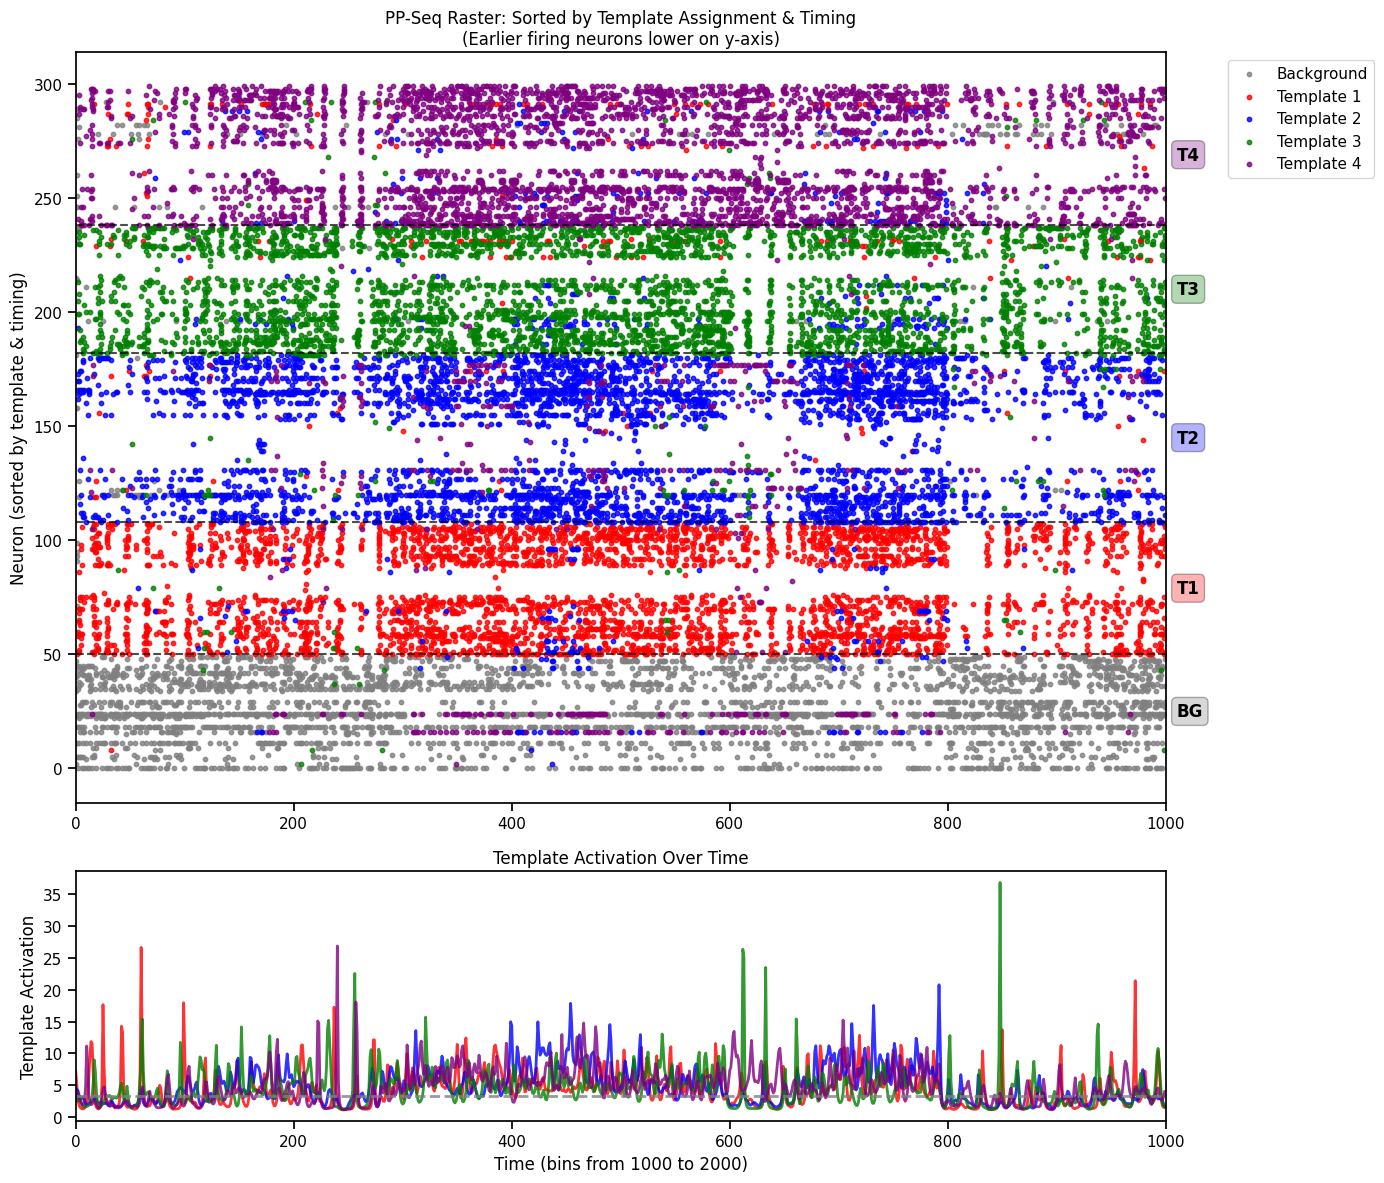

In [1110]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


def plot_ppseq_raster_sorted_by_templates(data, model, amplitudes, start=0, end=200, show_activation=True):
    """
    PP-Seq raster plot sorted by template membership and timing within template.
    Optimized version with vectorized operations instead of loops.
    
    Args:
        data: torch tensor (neurons, time)
        model: fitted PPSeq model
        amplitudes: amplitude tensor from model fit
        start, end: time window to plot
        show_activation: bool, whether to show template activation subplot
    """
    # Extract subset
    data_subset = data[:, start:end]
    amp_subset = amplitudes[:, start:end]
    
    # Get model parameters
    base_rates = model.base_rates.cpu()
    templates = model.templates.cpu()
    template_offsets = model.template_offsets.cpu()
    
    N, T = data_subset.shape
    K = templates.shape[0]  # number of templates
    D = templates.shape[2]  # template duration
    
    # Calculate which template is most active for each neuron at each time point
    template_contributions = torch.zeros(K, N, T)
    
    for k in range(K):
        # Convolve amplitude with flipped template
        conv_result = F.conv1d(
            amp_subset[[k], :], 
            torch.flip(templates[[k]].permute(1, 0, 2), [2]), 
            padding=D-1
        )[:, :-D+1]
        template_contributions[k] = conv_result
    
    # Add background
    background = base_rates.view(N, 1).expand(N, T)
    all_contributions = torch.cat([background.unsqueeze(0), template_contributions])
    
    # VECTORIZED: Find most responsible template for each spike
    spike_colors = torch.full_like(data_subset, -1, dtype=torch.long)  # -1 = no spike
    
    # Find all spike positions
    spike_rows, spike_cols = torch.where(data_subset > 0)
    
    # For each spike, get the template with max contribution
    if len(spike_rows) > 0:  # Only process if there are spikes
        max_contributors = torch.argmax(all_contributions[:, spike_rows, spike_cols], dim=0)
        spike_colors[spike_rows, spike_cols] = max_contributors
    
    # VECTORIZED: Calculate template strength for each neuron
    neuron_template_strength = torch.zeros(N, K+1)
    
    # For each template, count occurrences across all time points
    for k in range(K+1):
        neuron_template_strength[:, k] = torch.sum(spike_colors == k, dim=1).float()
    
    # Get primary template for each neuron
    primary_templates = torch.argmax(neuron_template_strength, dim=1)
    
    # Create sorting info: (neuron_idx, primary_template, timing_within_template)
    neuron_sort_info = []
    for n in range(N):
        primary_template = primary_templates[n].item()
        
        if primary_template == 0:  # Background
            timing = 0  # Background neurons don't have timing
        else:
            # Get the timing offset for this neuron in its primary template
            timing = template_offsets[primary_template - 1, n].item()
        
        neuron_sort_info.append((n, primary_template, timing))
    
    # Sort by: 1) primary template, 2) timing within template
    neuron_sort_info.sort(key=lambda x: (x[1], x[2]))
    
    # Extract sorted neuron indices
    sorted_indices = torch.tensor([info[0] for info in neuron_sort_info])
    sorted_spike_colors = spike_colors[sorted_indices, :]
    
    # Create the plot - single or double subplot
    if show_activation:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), 
                                       gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(14, 10))
    
    # Color scheme: background=gray, templates=colors
    colors = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'yellow']
    
    # UPPER PLOT: Raster plot
    # Plot spikes colored by template
    for color_idx in range(min(K+1, len(colors))):
        spike_coords = torch.where(sorted_spike_colors == color_idx)
        if len(spike_coords[0]) > 0:
            label = 'Background' if color_idx == 0 else f'Template {color_idx}'
            ax1.scatter(spike_coords[1].numpy(), spike_coords[0].numpy(), 
                       c=colors[color_idx], s=10, alpha=0.8, label=label)
    
    # Add template boundaries and labels
    current_template = neuron_sort_info[0][1]  # Template of first neuron
    boundaries = [0]  # Start with 0
    template_info = []  # (template_id, start_idx, end_idx)
    
    for i in range(1, len(neuron_sort_info)):
        if neuron_sort_info[i][1] != current_template:
            # End current template group
            template_info.append((current_template, boundaries[-1], i))
            boundaries.append(i)
            current_template = neuron_sort_info[i][1]
    
    # Add final template
    template_info.append((current_template, boundaries[-1], len(neuron_sort_info)))
    
    # Draw boundaries (skip the first one at 0)
    for boundary in boundaries[1:]:
        ax1.axhline(y=boundary, color='black', linewidth=1.5, alpha=0.7, linestyle='--')
    
    # Add template labels on the right
    for template_idx, start_y, end_y in template_info:
        y_pos = (start_y + end_y) / 2  # Middle of the template group
        
        if template_idx == 0:
            label_text = 'BG'  # Background
        else:
            label_text = f'T{template_idx}'
        
        ax1.text(T + 10, y_pos, label_text, ha='left', va='center', 
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[template_idx], alpha=0.3))
    
    # Set labels and title for raster plot
    if show_activation:
        ax1.set_ylabel('Neuron (sorted by template & timing)')
        ax1.set_title('PP-Seq Raster: Sorted by Template Assignment & Timing\n(Earlier firing neurons lower on y-axis)')
    else:
        ax1.set_xlabel(f'Time (bins from {start} to {end})')
        ax1.set_ylabel('Neuron (sorted by template & timing)')
        ax1.set_title('PP-Seq Raster: Sorted by Template Assignment & Timing\n(Earlier firing neurons lower on y-axis)')
    
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xlim(0, T)
    
    # LOWER PLOT: Template activation over time (if requested)
    if show_activation:
        time_bins = np.arange(T)
        
        # Plot each template's activation
        for k in range(K):
            template_activation = amp_subset[k, :].numpy()
            ax2.plot(time_bins, template_activation, 
                    color=colors[k+1], linewidth=2, 
                    label=f'Template {k+1}', alpha=0.8)
        
        # Add background activation (sum of background firing rates)
        background_activation = base_rates.sum().item() * np.ones(T)
        ax2.plot(time_bins, background_activation, 
                color=colors[0], linewidth=2, 
                label='Background', alpha=0.8, linestyle='--')
        
        ax2.set_xlabel(f'Time (bins from {start} to {end})')
        ax2.set_ylabel('Template Activation')
        ax2.set_title('Template Activation Over Time')
        # ax2.legend()
        # ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, T)
        
        # Print diagnostic info
        total_spikes = torch.sum(data_subset > 0).item()
        background_spikes = torch.sum(spike_colors == 0).item()
        sequence_spikes = total_spikes - background_spikes
        
        print(f"Spike Classification:")
        print(f"  Background: {background_spikes:,} ({background_spikes/total_spikes:.1%})")
        print(f"  Sequences:  {sequence_spikes:,} ({sequence_spikes/total_spikes:.1%})")
        print(f"  Total:      {total_spikes:,}")
        
        # Template activation summary
        print(f"\nTemplate Activation Summary:")
        for k in range(K):
            max_amp = torch.max(amp_subset[k, :]).item()
            mean_amp = torch.mean(amp_subset[k, :]).item()
            print(f"  Template {k+1}: max={max_amp:.2f}, mean={mean_amp:.2f}")
    
    plt.tight_layout()
    return fig

# Usage:
fig = plot_ppseq_raster_sorted_by_templates(
    torch_data.cpu(), 
    model, 
    amplitudes.cpu(), 
    start=1000, 
    end=2000,
    show_activation=True  # Set to False for raster only
)
plt.show()
fig.savefig('plots/ppseq_ibl_1000_2000_no_thresh', bbox_inches='tight')

Depth-sorted Classification (thresh=9.0, win=±5, winner must be window-active):
  Depth range: 358.7 to 1439.1 µm (shallow → deep)
  Sequence windows: 328 bins (65.6% of time)
  Detected peaks: 45
  Background spikes: 5,616 (74.4%)
  Sequence spikes:   1,937 (25.6%)
  Total spikes:      7,553
Depth-sorted Classification (thresh=9.0, win=±5, winner must be window-active):
  Depth range: 358.7 to 1439.1 µm (shallow → deep)
  Sequence windows: 76 bins (76.0% of time)
  Detected peaks: 12
  Background spikes: 1,137 (67.7%)
  Sequence spikes:   542 (32.3%)
  Total spikes:      1,679


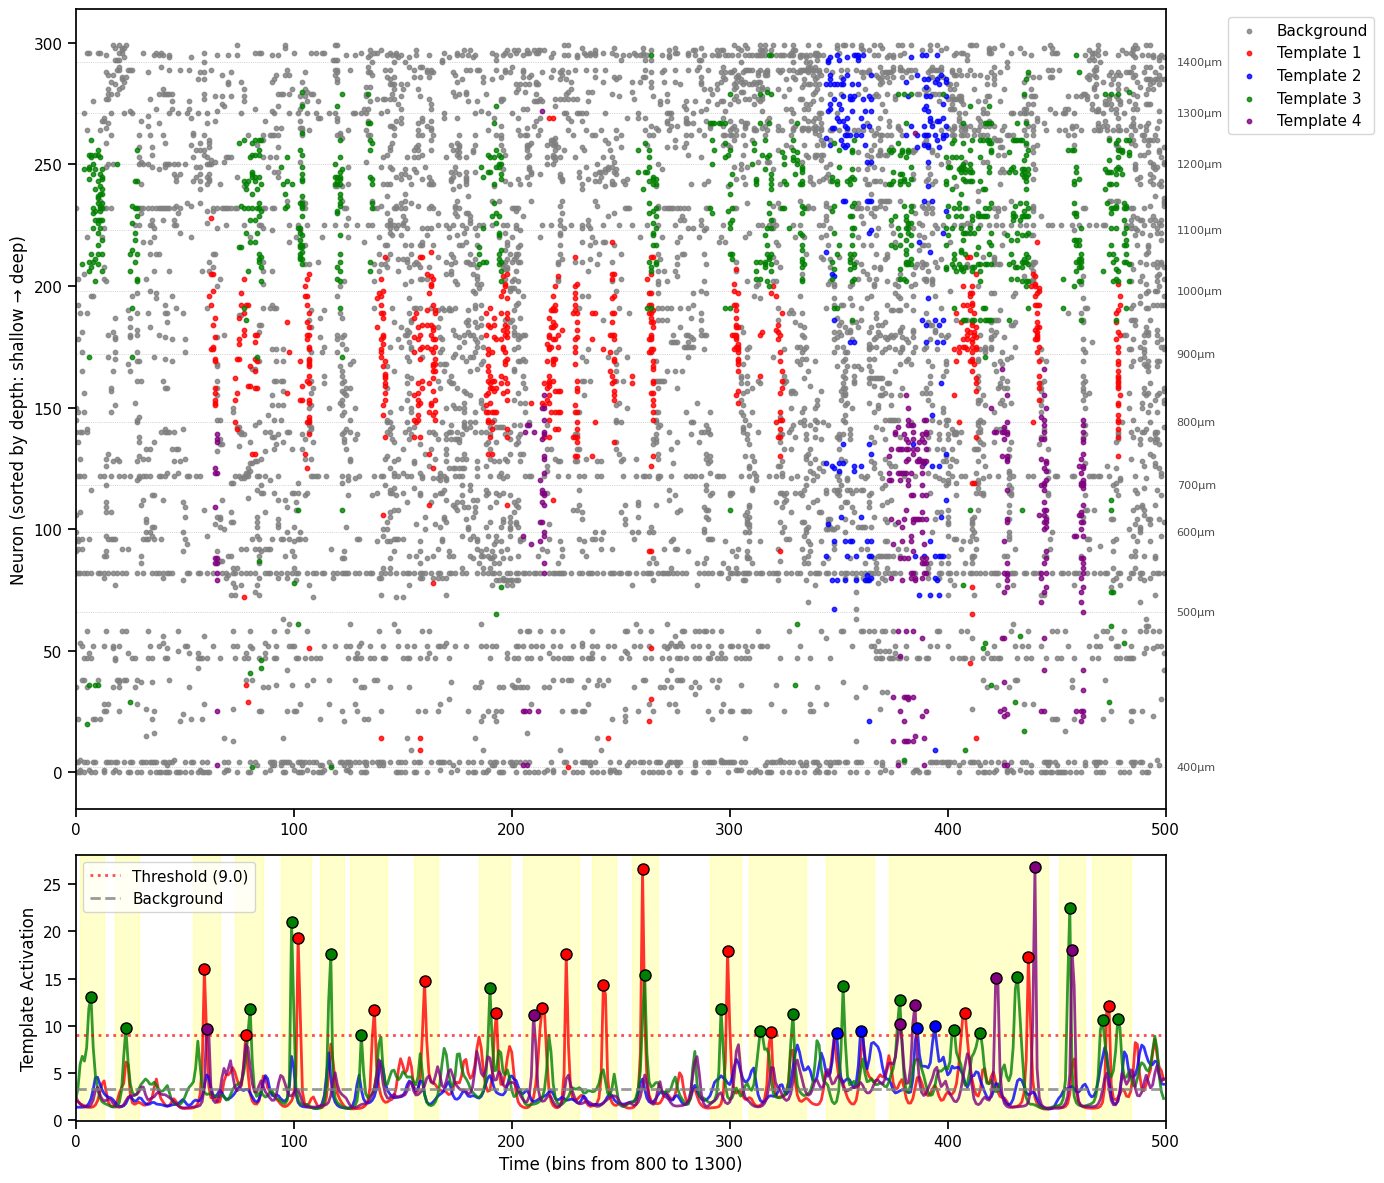

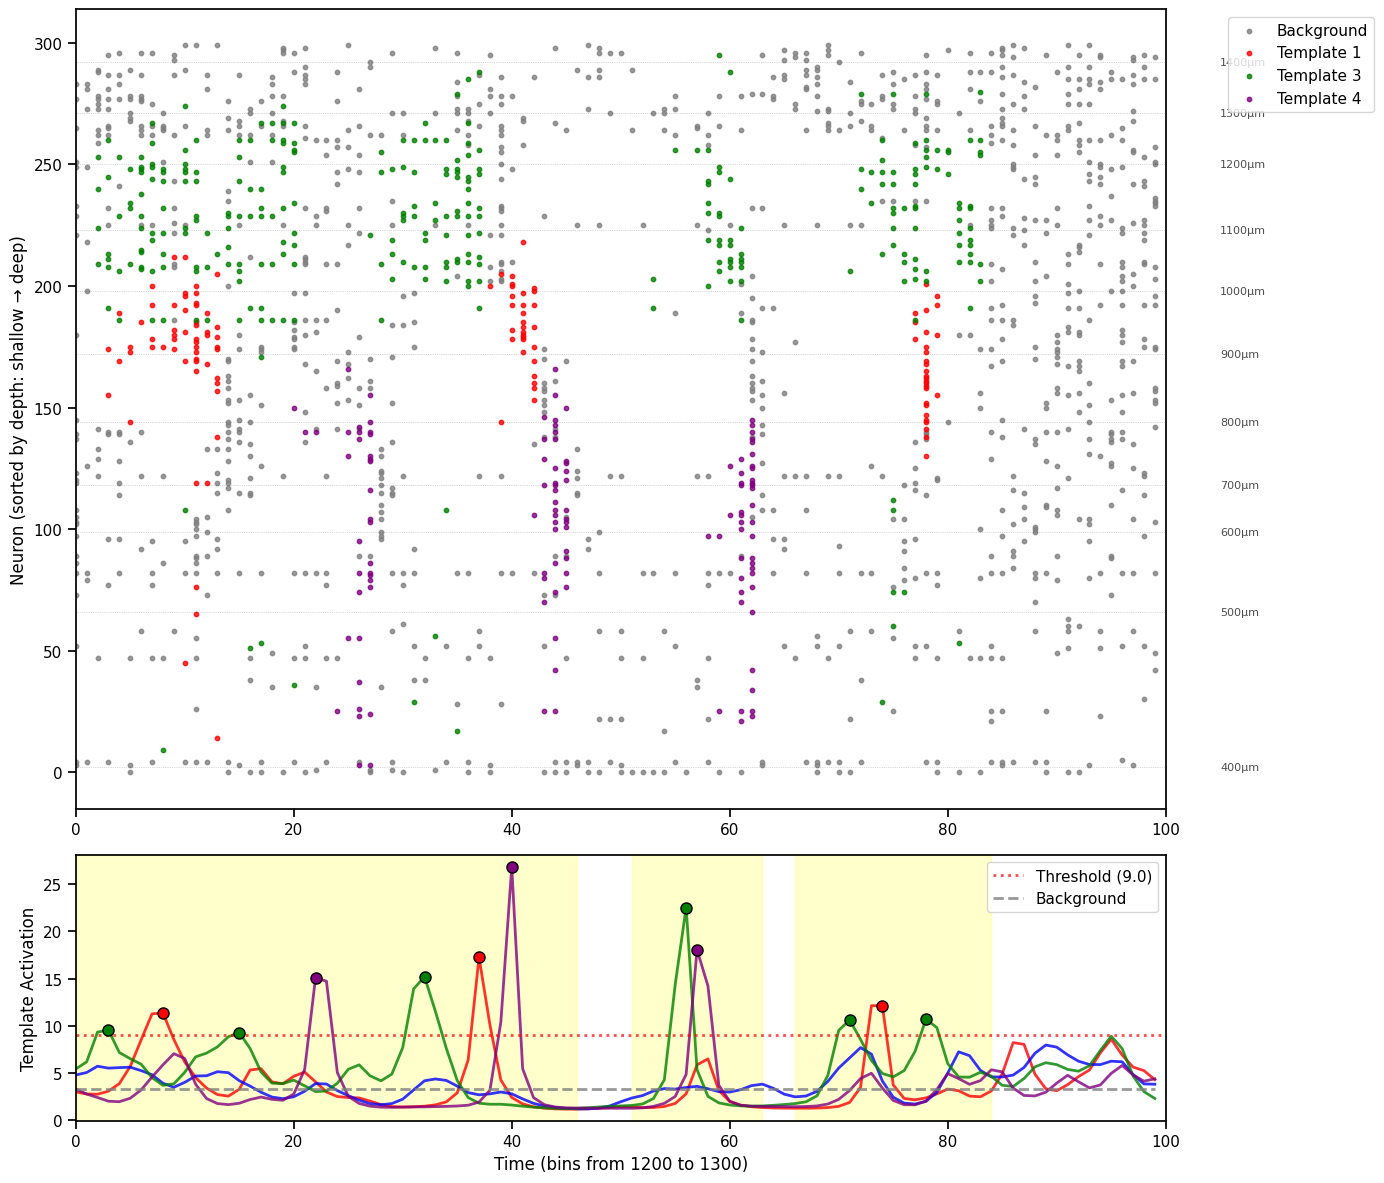

In [1125]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_ppseq_raster_with_windows_by_depth(data, model, amplitudes, neuron_depths, 
                                          start=0, end=200, 
                                          activation_threshold=15.0, window_half_size=5, 
                                          show_activation=True, plot_all_templates_on_thresh=True,
                                          sort_shallow_to_deep=True):
    """
    PP-Seq raster plot with window-based thresholding, sorted by neuron depth.
    
    Args:
        data: torch tensor (neurons, time)
        model: fitted PPSeq model
        amplitudes: amplitude tensor from model fit
        neuron_depths: array of depths for each neuron
        start, end: time window to plot
        activation_threshold: minimum template activation to trigger sequence window
        window_half_size: bins around peak (total window = 2*window_half_size + 1)
        show_activation: bool, whether to show template activation subplot
        plot_all_templates_on_thresh: bool, if True use winner-take-all across all templates
        sort_shallow_to_deep: bool, if True sort shallow to deep, else deep to shallow
    """
    # Extract subset
    data_subset = data[:, start:end]
    amp_subset = amplitudes[:, start:end]
    
    # Get model parameters
    base_rates = model.base_rates.cpu()
    templates = model.templates.cpu()
    
    N, T = data_subset.shape
    K = templates.shape[0]  # number of templates
    D = templates.shape[2]  # template duration
    
    # Calculate template contributions
    template_contributions = torch.zeros(K, N, T)
    
    for k in range(K):
        # Convolve amplitude with flipped template
        conv_result = F.conv1d(
            amp_subset[[k], :], 
            torch.flip(templates[[k]].permute(1, 0, 2), [2]), 
            padding=D-1
        )[:, :-D+1]
        template_contributions[k] = conv_result
    
    # Add background
    background = base_rates.view(N, 1).expand(N, T)
    all_contributions = torch.cat([background.unsqueeze(0), template_contributions])
    
    # FIND SEQUENCE WINDOWS: where template activation exceeds threshold
    sequence_mask = torch.zeros(T, dtype=torch.bool)
    peak_info = []  # Store (template_idx, peak_time, peak_value) for visualization
    window_active_templates = torch.zeros(T, K, dtype=torch.bool)  # Track which templates are active in each window
    
    for k in range(K):
        template_activation = amp_subset[k, :].numpy()
        
        # Find peaks above threshold
        peaks, properties = find_peaks(template_activation, height=activation_threshold, distance=window_half_size)
        
        for peak_idx in peaks:
            # Define window around peak
            window_start = max(0, peak_idx - window_half_size)
            window_end = min(T, peak_idx + window_half_size + 1)
            
            # Mark this window for sequence assignment
            sequence_mask[window_start:window_end] = True
            
            # Mark this template as active throughout this entire window
            window_active_templates[window_start:window_end, k] = True
            
            # Store peak info
            peak_info.append((k + 1, peak_idx, template_activation[peak_idx]))  # k+1 for 1-based template numbering
    
    # ASSIGN SPIKES: different logic based on plot_all_templates_on_thresh
    spike_colors = torch.full_like(data_subset, -1, dtype=torch.long)  # -1 = no spike
    
    # Find all spike positions
    spike_rows, spike_cols = torch.where(data_subset > 0)
    
    if len(spike_rows) > 0:  # Only process if there are spikes
        # Check which spikes fall within sequence windows
        in_sequence_window = sequence_mask[spike_cols]
        
        # For spikes in sequence windows: assign based on plot_all_templates_on_thresh setting
        seq_spike_rows = spike_rows[in_sequence_window]
        seq_spike_cols = spike_cols[in_sequence_window]
        
        if len(seq_spike_rows) > 0:
            if plot_all_templates_on_thresh:
                # Original behavior: winner-take-all across all templates
                seq_contributions = all_contributions[:, seq_spike_rows, seq_spike_cols]
                max_contributors = torch.argmax(seq_contributions, dim=0)
                spike_colors[seq_spike_rows, seq_spike_cols] = max_contributors
            else:
                # New behavior: templates active in window compete, but only if winner is active
                for i, (row, col) in enumerate(zip(seq_spike_rows, seq_spike_cols)):
                    # First, find which template has the highest contribution overall (including inactive ones)
                    all_contributions_at_spike = all_contributions[:, row, col]
                    overall_winner_idx = torch.argmax(all_contributions_at_spike).item()
                    
                    # Check if the overall winner is either background (0) or an active template (1-based)
                    if overall_winner_idx == 0:
                        # Background wins
                        spike_colors[row, col] = 0
                    else:
                        # Some template wins - check if it's active in this window
                        winning_template_idx = overall_winner_idx - 1  # Convert to 0-based template index
                        is_winner_active = window_active_templates[col, winning_template_idx].item()
                        
                        if is_winner_active:
                            # Winning template is active in window - color with it
                            spike_colors[row, col] = overall_winner_idx
                        else:
                            # Winning template is not active in window - assign to background
                            spike_colors[row, col] = 0
        
        # For spikes outside sequence windows: assign to background
        bg_spike_rows = spike_rows[~in_sequence_window]
        bg_spike_cols = spike_cols[~in_sequence_window]
        spike_colors[bg_spike_rows, bg_spike_cols] = 0  # Background
    
    # ===== SORT BY DEPTH INSTEAD OF TEMPLATE =====
    
    # Sort neurons by depth
    if sort_shallow_to_deep:
        sorted_indices = torch.tensor(np.argsort(neuron_depths))  # Shallow to deep
        depth_direction = "shallow → deep"
    else:
        sorted_indices = torch.tensor(np.argsort(neuron_depths)[::-1])  # Deep to shallow
        depth_direction = "deep → shallow"
    
    sorted_spike_colors = spike_colors[sorted_indices, :]
    sorted_depths = neuron_depths[sorted_indices]
    
    # Create the plot - single or double subplot
    if show_activation:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), 
                                       gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(14, 10))
    
    # Color scheme: background=gray, templates=colors
    colors = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'yellow']
    
    # UPPER PLOT: Raster plot
    # Plot spikes colored by template
    for color_idx in range(min(K+1, len(colors))):
        spike_coords = torch.where(sorted_spike_colors == color_idx)
        if len(spike_coords[0]) > 0:
            label = 'Background' if color_idx == 0 else f'Template {color_idx}'
            ax1.scatter(spike_coords[1].numpy(), spike_coords[0].numpy(), 
                       c=colors[color_idx], s=10, alpha=0.8, label=label)
    
    # Add depth markers/boundaries (optional - every 100µm or so)
    depth_range = sorted_depths.max() - sorted_depths.min()
    if depth_range > 200:  # Only add markers if there's substantial depth range
        # Find approximate depth boundaries every ~100µm
        depth_step = 100  # µm
        depth_min = int(sorted_depths.min() // depth_step) * depth_step
        depth_max = int(sorted_depths.max() // depth_step + 1) * depth_step
        
        for depth_mark in range(depth_min + depth_step, depth_max, depth_step):
            # Find neuron closest to this depth
            depth_diff = np.abs(sorted_depths - depth_mark)
            closest_neuron_idx = np.argmin(depth_diff)
            
            if depth_diff[closest_neuron_idx] < depth_step/2:  # Only if reasonably close
                ax1.axhline(y=closest_neuron_idx, color='black', linewidth=0.5, 
                           alpha=0.3, linestyle=':')
                ax1.text(T + 5, closest_neuron_idx, f'{depth_mark}µm', 
                        ha='left', va='center', fontsize=8, alpha=0.7)
    
    # Set labels and title for raster plot
    threshold_str = f"thresh={activation_threshold}, win=±{window_half_size}"
    coloring_mode = "all templates compete" if plot_all_templates_on_thresh else "winner must be window-active"
    
    if show_activation:
        ax1.set_ylabel(f'Neuron (sorted by depth: {depth_direction})')
    else:
        ax1.set_xlabel(f'Time (bins from {start} to {end})')
        ax1.set_ylabel(f'Neuron (sorted by depth: {depth_direction})')
    
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xlim(0, T)
    
    # LOWER PLOT: Template activation over time (if requested)
    if show_activation:
        time_bins = np.arange(T)
        
        # Plot each template's activation
        for k in range(K):
            template_activation = amp_subset[k, :].numpy()
            ax2.plot(time_bins, template_activation, 
                    color=colors[k+1], linewidth=2, 
                    label=None, alpha=0.8)
        
        # Add threshold line
        ax2.axhline(y=activation_threshold, color='red', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'Threshold ({activation_threshold})')
        
        # Mark detected peaks
        for template_idx, peak_time, peak_value in peak_info:
            ax2.plot(peak_time, peak_value, 'o', color=colors[template_idx], 
                    markersize=8, markeredgecolor='black', markeredgewidth=1)
        
        # Add sequence windows as vertical shaded regions
        for window_start in range(T):
            if sequence_mask[window_start] and (window_start == 0 or not sequence_mask[window_start-1]):
                # Start of a new window
                window_end = window_start
                while window_end < T and sequence_mask[window_end]:
                    window_end += 1
                ax2.axvspan(window_start, window_end, alpha=0.2, color='yellow')
        
        # Add background activation (sum of background firing rates)
        background_activation = base_rates.sum().item() * np.ones(T)
        ax2.plot(time_bins, background_activation, 
                color=colors[0], linewidth=2, 
                label='Background', alpha=0.8, linestyle='--')
        
        ax2.set_xlabel(f'Time (bins from {start} to {end})')
        ax2.set_ylabel('Template Activation')
        ax2.legend()
        ax2.set_xlim(0, T)
        
        # Print diagnostic info
        total_spikes = torch.sum(data_subset > 0).item()
        background_spikes = torch.sum(spike_colors == 0).item()
        sequence_spikes = total_spikes - background_spikes
        sequence_bins = torch.sum(sequence_mask).item()
        
        print(f"Depth-sorted Classification ({threshold_str}, {coloring_mode}):")
        print(f"  Depth range: {sorted_depths.min():.1f} to {sorted_depths.max():.1f} µm ({depth_direction})")
        print(f"  Sequence windows: {sequence_bins} bins ({sequence_bins/T:.1%} of time)")
        print(f"  Detected peaks: {len(peak_info)}")
        print(f"  Background spikes: {background_spikes:,} ({background_spikes/total_spikes:.1%})")
        print(f"  Sequence spikes:   {sequence_spikes:,} ({sequence_spikes/total_spikes:.1%})")
        print(f"  Total spikes:      {total_spikes:,}")
    
    plt.tight_layout()
    return fig


# Usage examples:
plot_all_templates_on_thresh = False

if plot_all_templates_on_thresh:
    ext = '_all_temps_depth'
else:
    ext = '_depth'

# Default: threshold=9, window=±5 bins, sorted by depth
fig2 = plot_ppseq_raster_with_windows_by_depth(
    torch_data.cpu(), model, amplitudes.cpu(), neuron_depths,
    start=800, end=1300,
    activation_threshold=9.0, window_half_size=5,
    show_activation=True,
    plot_all_templates_on_thresh=plot_all_templates_on_thresh,
    sort_shallow_to_deep=True  # True = shallow to deep, False = deep to shallow
)

fig2.savefig(f'plots/ibl_ppseq_bin800_bin1300{ext}.png', bbox_inches='tight')

fig3 = plot_ppseq_raster_with_windows_by_depth(
    torch_data.cpu(), model, amplitudes.cpu(), neuron_depths,
    start=1200, end=1300,
    activation_threshold=9.0, window_half_size=5,
    show_activation=True,
    plot_all_templates_on_thresh=plot_all_templates_on_thresh,
    sort_shallow_to_deep=True
)
fig3.savefig(f'plots/ibl_ppseq_bin1200_bin1300{ext}.png', bbox_inches='tight')

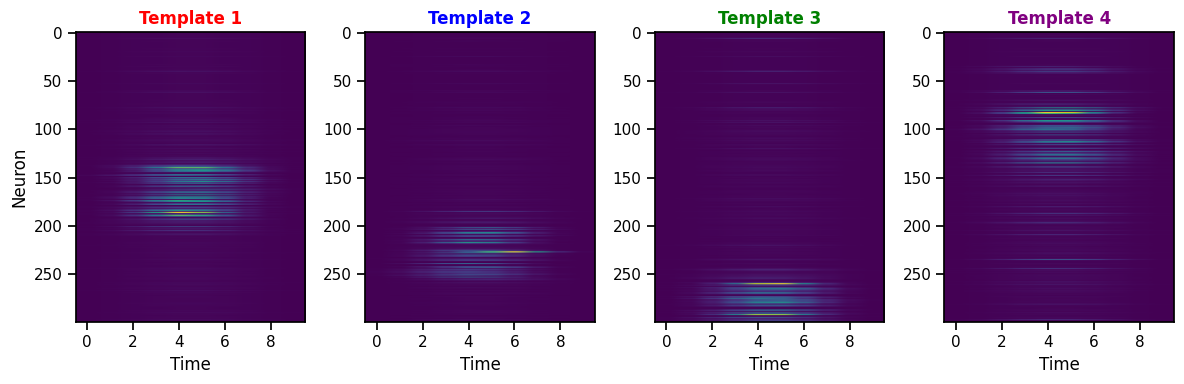

In [1061]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_templates_summary(model):
    """
    Create a compact summary view of all templates.
    """
    templates = model.templates.cpu().numpy()  # Shape: [K, N, D]
    K, N, D = templates.shape
    
    fig, axes = plt.subplots(1, K, figsize=(3*K, 4))
    if K == 1:
        axes = axes.reshape(-1, 1)  # Ensure 2D for single template
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan']
    time_points = np.arange(D)
    
    for k in range(K):
        template = templates[k]  # [N, D]
        total_activity = np.sum(template, axis=0)
        color = colors[k % len(colors)]
        
        # Top row: Template heatmaps
        im = axes[k].imshow(template, aspect='auto', cmap='viridis')
        axes[k].set_title(f'Template {k+1}', color=color, fontweight='bold')
        axes[k].set_xlabel('Time')
        if k == 0:
            axes[ k].set_ylabel('Neuron')
        
        
    # plt.suptitle('All Templates Overview', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig
    


# Compact summary view
fig3 = plot_templates_summary(model)
fig3.savefig('plots/ibl_ppseq_templates.png', bbox_inches='tight')
plt.show()

# END OF ANALYSIS

In [ ]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# def plot_ppseq_raster_with_windows(data, model, amplitudes, start=0, end=200, 
#                                  activation_threshold=15.0, window_half_size=5, 
#                                  show_activation=True, plot_all_templates_on_thresh=True):
#     """
#     PP-Seq raster plot with window-based thresholding around activation peaks.
    
#     Args:
#         data: torch tensor (neurons, time)
#         model: fitted PPSeq model
#         amplitudes: amplitude tensor from model fit
#         start, end: time window to plot
#         activation_threshold: minimum template activation to trigger sequence window
#         window_half_size: bins around peak (total window = 2*window_half_size + 1)
#         show_activation: bool, whether to show template activation subplot
#         plot_all_templates_on_thresh: bool, if True use winner-take-all across all templates,
#                                      if False only color spikes if the overall winner template
#                                      is active (crosses threshold) somewhere in that window
#     """
#     # Extract subset
#     data_subset = data[:, start:end]
#     amp_subset = amplitudes[:, start:end]
    
#     # Get model parameters
#     base_rates = model.base_rates.cpu()
#     templates = model.templates.cpu()
#     template_offsets = model.template_offsets.cpu()
    
#     N, T = data_subset.shape
#     K = templates.shape[0]  # number of templates
#     D = templates.shape[2]  # template duration
    
#     # Calculate template contributions
#     template_contributions = torch.zeros(K, N, T)
    
#     for k in range(K):
#         # Convolve amplitude with flipped template
#         conv_result = F.conv1d(
#             amp_subset[[k], :], 
#             torch.flip(templates[[k]].permute(1, 0, 2), [2]), 
#             padding=D-1
#         )[:, :-D+1]
#         template_contributions[k] = conv_result
    
#     # Add background
#     background = base_rates.view(N, 1).expand(N, T)
#     all_contributions = torch.cat([background.unsqueeze(0), template_contributions])
    
#     # FIND SEQUENCE WINDOWS: where template activation exceeds threshold
#     sequence_mask = torch.zeros(T, dtype=torch.bool)
#     peak_info = []  # Store (template_idx, peak_time, peak_value) for visualization
#     window_active_templates = torch.zeros(T, K, dtype=torch.bool)  # Track which templates are active in each window
    
#     for k in range(K):
#         template_activation = amp_subset[k, :].numpy()
        
#         # Find peaks above threshold
#         peaks, properties = find_peaks(template_activation, height=activation_threshold, distance=window_half_size)
        
#         for peak_idx in peaks:
#             # Define window around peak
#             window_start = max(0, peak_idx - window_half_size)
#             window_end = min(T, peak_idx + window_half_size + 1)
            
#             # Mark this window for sequence assignment
#             sequence_mask[window_start:window_end] = True
            
#             # Mark this template as active throughout this entire window
#             window_active_templates[window_start:window_end, k] = True
            
#             # Store peak info
#             peak_info.append((k + 1, peak_idx, template_activation[peak_idx]))  # k+1 for 1-based template numbering
    
#     # ASSIGN SPIKES: different logic based on plot_all_templates_on_thresh
#     spike_colors = torch.full_like(data_subset, -1, dtype=torch.long)  # -1 = no spike
    
#     # Find all spike positions
#     spike_rows, spike_cols = torch.where(data_subset > 0)
    
#     if len(spike_rows) > 0:  # Only process if there are spikes
#         # Check which spikes fall within sequence windows
#         in_sequence_window = sequence_mask[spike_cols]
        
#         # For spikes in sequence windows: assign based on plot_all_templates_on_thresh setting
#         seq_spike_rows = spike_rows[in_sequence_window]
#         seq_spike_cols = spike_cols[in_sequence_window]
        
#         if len(seq_spike_rows) > 0:
#             if plot_all_templates_on_thresh:
#                 # Original behavior: winner-take-all across all templates
#                 seq_contributions = all_contributions[:, seq_spike_rows, seq_spike_cols]
#                 max_contributors = torch.argmax(seq_contributions, dim=0)
#                 spike_colors[seq_spike_rows, seq_spike_cols] = max_contributors
#             else:
#                 # New behavior: templates active in window compete, but only if winner is active
#                 for i, (row, col) in enumerate(zip(seq_spike_rows, seq_spike_cols)):
#                     # First, find which template has the highest contribution overall (including inactive ones)
#                     all_contributions_at_spike = all_contributions[:, row, col]
#                     overall_winner_idx = torch.argmax(all_contributions_at_spike).item()
                    
#                     # Check if the overall winner is either background (0) or an active template (1-based)
#                     if overall_winner_idx == 0:
#                         # Background wins
#                         spike_colors[row, col] = 0
#                     else:
#                         # Some template wins - check if it's active in this window
#                         winning_template_idx = overall_winner_idx - 1  # Convert to 0-based template index
#                         is_winner_active = window_active_templates[col, winning_template_idx].item()
                        
#                         if is_winner_active:
#                             # Winning template is active in window - color with it
#                             spike_colors[row, col] = overall_winner_idx
#                         else:
#                             # Winning template is not active in window - assign to background
#                             spike_colors[row, col] = 0
        
#         # For spikes outside sequence windows: assign to background
#         bg_spike_rows = spike_rows[~in_sequence_window]
#         bg_spike_cols = spike_cols[~in_sequence_window]
#         spike_colors[bg_spike_rows, bg_spike_cols] = 0  # Background
    
#     # VECTORIZED: Calculate template strength for each neuron
#     neuron_template_strength = torch.zeros(N, K+1)
    
#     # For each template, count occurrences across all time points
#     for k in range(K+1):
#         neuron_template_strength[:, k] = torch.sum(spike_colors == k, dim=1).float()
    
#     # Get primary template for each neuron
#     primary_templates = torch.argmax(neuron_template_strength, dim=1)
    
#     # Create sorting info: (neuron_idx, primary_template, timing_within_template)
#     neuron_sort_info = []
#     for n in range(N):
#         primary_template = primary_templates[n].item()
        
#         if primary_template == 0:  # Background
#             timing = 0  # Background neurons don't have timing
#         else:
#             # Get the timing offset for this neuron in its primary template
#             timing = template_offsets[primary_template - 1, n].item()
        
#         neuron_sort_info.append((n, primary_template, timing))
    
#     # Sort by: 1) primary template, 2) timing within template
#     neuron_sort_info.sort(key=lambda x: (x[1], x[2]))
    
#     # Extract sorted neuron indices
#     sorted_indices = torch.tensor([info[0] for info in neuron_sort_info])
#     sorted_spike_colors = spike_colors[sorted_indices, :]
    
#     # Create the plot - single or double subplot
#     if show_activation:
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), 
#                                        gridspec_kw={'height_ratios': [3, 1]})
#     else:
#         fig, ax1 = plt.subplots(figsize=(14, 10))
    
#     # Color scheme: background=gray, templates=colors
#     colors = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'yellow']
    
#     # UPPER PLOT: Raster plot
#     # Plot spikes colored by template
#     for color_idx in range(min(K+1, len(colors))):
#         spike_coords = torch.where(sorted_spike_colors == color_idx)
#         if len(spike_coords[0]) > 0:
#             label = 'Background' if color_idx == 0 else f'Template {color_idx}'
#             ax1.scatter(spike_coords[1].numpy(), spike_coords[0].numpy(), 
#                        c=colors[color_idx], s=10, alpha=0.8, label=label)
    
#     # Add template boundaries and labels
#     current_template = neuron_sort_info[0][1]  # Template of first neuron
#     boundaries = [0]  # Start with 0
#     template_info = []  # (template_id, start_idx, end_idx)
    
#     for i in range(1, len(neuron_sort_info)):
#         if neuron_sort_info[i][1] != current_template:
#             # End current template group
#             template_info.append((current_template, boundaries[-1], i))
#             boundaries.append(i)
#             current_template = neuron_sort_info[i][1]
    
#     # Add final template
#     template_info.append((current_template, boundaries[-1], len(neuron_sort_info)))
    
#     # Draw boundaries (skip the first one at 0)
#     for boundary in boundaries[1:]:
#         ax1.axhline(y=boundary, color='black', linewidth=1.5, alpha=0.7, linestyle='--')
    
#     # Add template labels on the right
#     for template_idx, start_y, end_y in template_info:
#         y_pos = (start_y + end_y) / 2  # Middle of the template group
        
#         if template_idx == 0:
#             label_text = 'BG'  # Background
#         else:
#             label_text = f'T{template_idx}'
        
#         ax1.text(T + 10, y_pos, label_text, ha='left', va='center', 
#                fontsize=12, fontweight='bold',
#                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[template_idx], alpha=0.3))
    
#     # Set labels and title for raster plot
#     threshold_str = f"thresh={activation_threshold}, win=±{window_half_size}"
#     coloring_mode = "all templates compete" if plot_all_templates_on_thresh else "winner must be window-active"
    
#     if show_activation:
#         ax1.set_ylabel('Neuron (sorted by template + timing)')
#         # ax1.set_title(f'PP-Seq Raster with Window Thresholding ({threshold_str})\nColoring: {coloring_mode}')
#     else:
#         ax1.set_xlabel(f'Time (bins from {start} to {end})')
#         ax1.set_ylabel('Neuron (sorted by template + timing)')
#         # ax1.set_title(f'PP-Seq Raster with Window Thresholding ({threshold_str})\nColoring: {coloring_mode}')
    
#     ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax1.set_xlim(0, T)
    
#     # LOWER PLOT: Template activation over time (if requested)
#     if show_activation:
#         time_bins = np.arange(T)
        
#         # Plot each template's activation
#         for k in range(K):
#             template_activation = amp_subset[k, :].numpy()
#             ax2.plot(time_bins, template_activation, 
#                     color=colors[k+1], linewidth=2, 
#                     label=None, alpha=0.8)
        
#         # Add threshold line
#         ax2.axhline(y=activation_threshold, color='red', linestyle=':', 
#                    linewidth=2, alpha=0.7, label=f'Threshold ({activation_threshold})')
        
#         # Mark detected peaks
#         for template_idx, peak_time, peak_value in peak_info:
#             ax2.plot(peak_time, peak_value, 'o', color=colors[template_idx], 
#                     markersize=8, markeredgecolor='black', markeredgewidth=1)
        
#         # Add sequence windows as vertical shaded regions
#         for window_start in range(T):
#             if sequence_mask[window_start] and (window_start == 0 or not sequence_mask[window_start-1]):
#                 # Start of a new window
#                 window_end = window_start
#                 while window_end < T and sequence_mask[window_end]:
#                     window_end += 1
#                 ax2.axvspan(window_start, window_end, alpha=0.2, color='yellow')
        
#         # Add background activation (sum of background firing rates)
#         background_activation = base_rates.sum().item() * np.ones(T)
#         ax2.plot(time_bins, background_activation, 
#                 color=colors[0], linewidth=2, 
#                 label='Background', alpha=0.8, linestyle='--')
        
#         ax2.set_xlabel(f'Time (bins from {start} to {end})')
#         ax2.set_ylabel('Template Activation')
#         # ax2.set_title('Template activation Over Time')
#         ax2.legend()
#         ax2.set_xlim(0, T)
        
#         # Print diagnostic info
#         total_spikes = torch.sum(data_subset > 0).item()
#         background_spikes = torch.sum(spike_colors == 0).item()
#         sequence_spikes = total_spikes - background_spikes
#         sequence_bins = torch.sum(sequence_mask).item()
        
#         print(f"Window-based Classification ({threshold_str}, {coloring_mode}):")
#         print(f"  Sequence windows: {sequence_bins} bins ({sequence_bins/T:.1%} of time)")
#         print(f"  Detected peaks: {len(peak_info)}")
#         print(f"  Background spikes: {background_spikes:,} ({background_spikes/total_spikes:.1%})")
#         print(f"  Sequence spikes:   {sequence_spikes:,} ({sequence_spikes/total_spikes:.1%})")
#         print(f"  Total spikes:      {total_spikes:,}")
    
#     plt.tight_layout()
#     return fig


# # Usage examples:
# plot_all_templates_on_thresh = False

# if plot_all_templates_on_thresh:
#     ext = '_all_temps'
# else:
#     ext = ''
    

# # Default: threshold=15, window=±5 bins
# fig2 = plot_ppseq_raster_with_windows(
#     torch_data.cpu(), model, amplitudes.cpu(), 
#     start=800, end=1300,
#     activation_threshold=9.0, window_half_size=5,
#     show_activation=True,
#     plot_all_templates_on_thresh=plot_all_templates_on_thresh
# )

# fig2.savefig(f'plots/ibl_ppseq_bin1000_bin1300{ext}.png',  bbox_inches='tight')



# fig3 = plot_ppseq_raster_with_windows(
#     torch_data.cpu(), model, amplitudes.cpu(), 
#     start=1200, end=1300,
#     activation_threshold=9.0, window_half_size=5,
#     show_activation=True,
#     plot_all_templates_on_thresh=plot_all_templates_on_thresh
# )
# fig3.savefig(f'plots/ibl_ppseq_bin1200_bin1300{ext}.png', bbox_inches='tight')


Window-based Classification (thresh=13.0, win=±5, triggering template must win):
  Sequence windows: 51 bins (51.0% of time)
  Detected peaks: 7
  Background spikes: 1,502 (89.5%)
  Sequence spikes:   177 (10.5%)
  Total spikes:      1,679


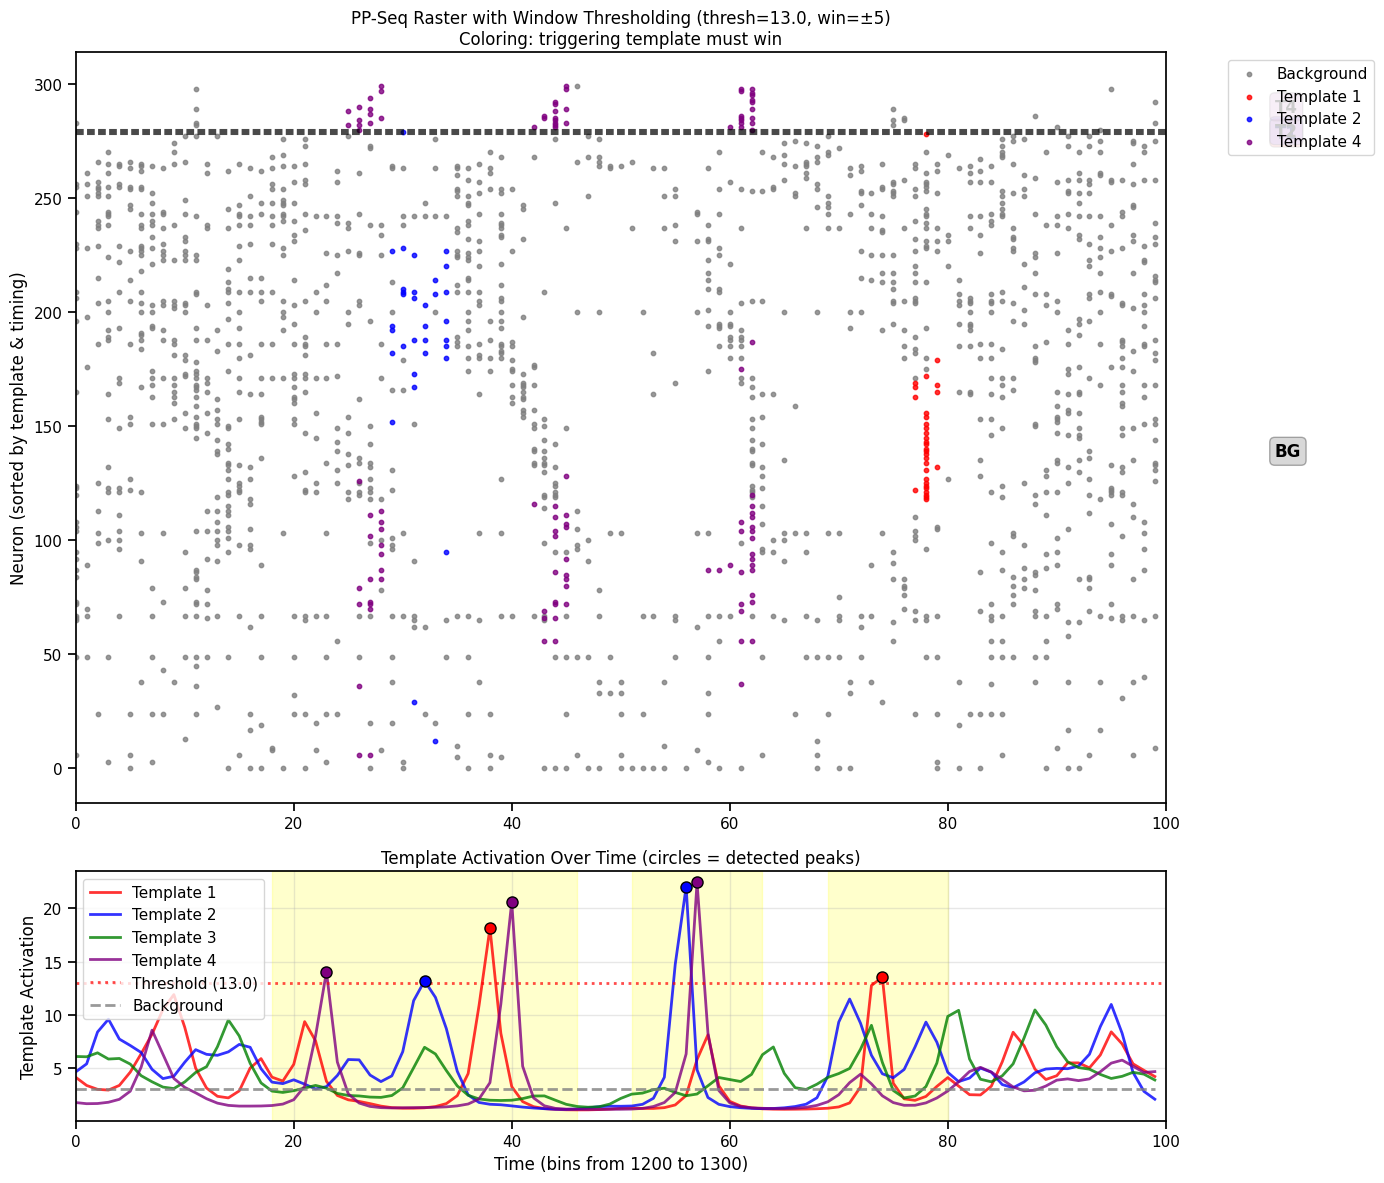

In [1044]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_ppseq_raster_with_windows(data, model, amplitudes, start=0, end=200, 
                                 activation_threshold=15.0, window_half_size=5, 
                                 show_activation=True, plot_all_templates_on_thresh=True):
    """
    PP-Seq raster plot with window-based thresholding around activation peaks.
    Only assigns spikes to templates within windows around high activation periods.
    
    Args:
        data: torch tensor (neurons, time)
        model: fitted PPSeq model
        amplitudes: amplitude tensor from model fit
        start, end: time window to plot
        activation_threshold: minimum template activation to trigger sequence window
        window_half_size: bins around peak (total window = 2*window_half_size + 1)
        show_activation: bool, whether to show template activation subplot
        plot_all_templates_on_thresh: bool, if True use winner-take-all across all templates,
                                     if False only color spikes that are actually best explained 
                                     by the template that triggered the window
    """
    # Extract subset
    data_subset = data[:, start:end]
    amp_subset = amplitudes[:, start:end]
    
    # Get model parameters
    base_rates = model.base_rates.cpu()
    templates = model.templates.cpu()
    template_offsets = model.template_offsets.cpu()
    
    N, T = data_subset.shape
    K = templates.shape[0]  # number of templates
    D = templates.shape[2]  # template duration
    
    # Calculate template contributions
    template_contributions = torch.zeros(K, N, T)
    
    for k in range(K):
        # Convolve amplitude with flipped template
        conv_result = F.conv1d(
            amp_subset[[k], :], 
            torch.flip(templates[[k]].permute(1, 0, 2), [2]), 
            padding=D-1
        )[:, :-D+1]
        template_contributions[k] = conv_result
    
    # Add background
    background = base_rates.view(N, 1).expand(N, T)
    all_contributions = torch.cat([background.unsqueeze(0), template_contributions])
    
    # FIND SEQUENCE WINDOWS: where template activation exceeds threshold
    sequence_mask = torch.zeros(T, dtype=torch.bool)
    peak_info = []  # Store (template_idx, peak_time, peak_value) for visualization
    window_template_map = torch.full((T,), -1, dtype=torch.long)  # Track which template triggered each time point
    
    for k in range(K):
        template_activation = amp_subset[k, :].numpy()
        
        # Find peaks above threshold
        peaks, properties = find_peaks(template_activation, height=activation_threshold, distance=window_half_size)
        
        for peak_idx in peaks:
            # Define window around peak
            window_start = max(0, peak_idx - window_half_size)
            window_end = min(T, peak_idx + window_half_size + 1)
            
            # Mark this window for sequence assignment
            sequence_mask[window_start:window_end] = True
            
            # Track which template triggered this window (for both modes, but used differently)
            window_template_map[window_start:window_end] = k + 1  # k+1 for 1-based template indexing
            
            # Store peak info
            peak_info.append((k + 1, peak_idx, template_activation[peak_idx]))  # k+1 for 1-based template numbering
    
    # ASSIGN SPIKES: different logic based on plot_all_templates_on_thresh
    spike_colors = torch.full_like(data_subset, -1, dtype=torch.long)  # -1 = no spike
    
    # Find all spike positions
    spike_rows, spike_cols = torch.where(data_subset > 0)
    
    if len(spike_rows) > 0:  # Only process if there are spikes
        # Check which spikes fall within sequence windows
        in_sequence_window = sequence_mask[spike_cols]
        
        # For spikes in sequence windows: assign based on plot_all_templates_on_thresh setting
        seq_spike_rows = spike_rows[in_sequence_window]
        seq_spike_cols = spike_cols[in_sequence_window]
        
        if len(seq_spike_rows) > 0:
            if plot_all_templates_on_thresh:
                # Original behavior: winner-take-all across all templates
                seq_contributions = all_contributions[:, seq_spike_rows, seq_spike_cols]
                max_contributors = torch.argmax(seq_contributions, dim=0)
                spike_colors[seq_spike_rows, seq_spike_cols] = max_contributors
            else:
                # New behavior: only color spikes if they are actually best explained by the triggering template
                seq_contributions = all_contributions[:, seq_spike_rows, seq_spike_cols]
                max_contributors = torch.argmax(seq_contributions, dim=0)  # Overall winners
                
                for i, (row, col) in enumerate(zip(seq_spike_rows, seq_spike_cols)):
                    triggering_template = window_template_map[col].item()
                    overall_winner = max_contributors[i].item()
                    
                    # Only color if the triggering template is actually the winner for this spike
                    if triggering_template == overall_winner:
                        spike_colors[row, col] = triggering_template
                    else:
                        spike_colors[row, col] = 0  # Background (even if another template won)
        
        # For spikes outside sequence windows: assign to background
        bg_spike_rows = spike_rows[~in_sequence_window]
        bg_spike_cols = spike_cols[~in_sequence_window]
        spike_colors[bg_spike_rows, bg_spike_cols] = 0  # Background
    
    # VECTORIZED: Calculate template strength for each neuron
    neuron_template_strength = torch.zeros(N, K+1)
    
    # For each template, count occurrences across all time points
    for k in range(K+1):
        neuron_template_strength[:, k] = torch.sum(spike_colors == k, dim=1).float()
    
    # Get primary template for each neuron
    primary_templates = torch.argmax(neuron_template_strength, dim=1)
    
    # Create sorting info: (neuron_idx, primary_template, timing_within_template)
    neuron_sort_info = []
    for n in range(N):
        primary_template = primary_templates[n].item()
        
        if primary_template == 0:  # Background
            timing = 0  # Background neurons don't have timing
        else:
            # Get the timing offset for this neuron in its primary template
            timing = template_offsets[primary_template - 1, n].item()
        
        neuron_sort_info.append((n, primary_template, timing))
    
    # Sort by: 1) primary template, 2) timing within template
    neuron_sort_info.sort(key=lambda x: (x[1], x[2]))
    
    # Extract sorted neuron indices
    sorted_indices = torch.tensor([info[0] for info in neuron_sort_info])
    sorted_spike_colors = spike_colors[sorted_indices, :]
    
    # Create the plot - single or double subplot
    if show_activation:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), 
                                       gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(14, 10))
    
    # Color scheme: background=gray, templates=colors
    colors = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'yellow']
    
    # UPPER PLOT: Raster plot
    # Plot spikes colored by template
    for color_idx in range(min(K+1, len(colors))):
        spike_coords = torch.where(sorted_spike_colors == color_idx)
        if len(spike_coords[0]) > 0:
            label = 'Background' if color_idx == 0 else f'Template {color_idx}'
            ax1.scatter(spike_coords[1].numpy(), spike_coords[0].numpy(), 
                       c=colors[color_idx], s=10, alpha=0.8, label=label)
    
    # Add template boundaries and labels
    current_template = neuron_sort_info[0][1]  # Template of first neuron
    boundaries = [0]  # Start with 0
    template_info = []  # (template_id, start_idx, end_idx)
    
    for i in range(1, len(neuron_sort_info)):
        if neuron_sort_info[i][1] != current_template:
            # End current template group
            template_info.append((current_template, boundaries[-1], i))
            boundaries.append(i)
            current_template = neuron_sort_info[i][1]
    
    # Add final template
    template_info.append((current_template, boundaries[-1], len(neuron_sort_info)))
    
    # Draw boundaries (skip the first one at 0)
    for boundary in boundaries[1:]:
        ax1.axhline(y=boundary, color='black', linewidth=1.5, alpha=0.7, linestyle='--')
    
    # Add template labels on the right
    for template_idx, start_y, end_y in template_info:
        y_pos = (start_y + end_y) / 2  # Middle of the template group
        
        if template_idx == 0:
            label_text = 'BG'  # Background
        else:
            label_text = f'T{template_idx}'
        
        ax1.text(T + 10, y_pos, label_text, ha='left', va='center', 
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[template_idx], alpha=0.3))
    
    # Set labels and title for raster plot
    threshold_str = f"thresh={activation_threshold}, win=±{window_half_size}"
    coloring_mode = "all templates compete" if plot_all_templates_on_thresh else "triggering template must win"
    
    if show_activation:
        ax1.set_ylabel('Neuron (sorted by template & timing)')
        ax1.set_title(f'PP-Seq Raster with Window Thresholding ({threshold_str})\nColoring: {coloring_mode}')
    else:
        ax1.set_xlabel(f'Time (bins from {start} to {end})')
        ax1.set_ylabel('Neuron (sorted by template & timing)')
        ax1.set_title(f'PP-Seq Raster with Window Thresholding ({threshold_str})\nColoring: {coloring_mode}')
    
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xlim(0, T)
    
    # LOWER PLOT: Template activation over time (if requested)
    if show_activation:
        time_bins = np.arange(T)
        
        # Plot each template's activation
        for k in range(K):
            template_activation = amp_subset[k, :].numpy()
            ax2.plot(time_bins, template_activation, 
                    color=colors[k+1], linewidth=2, 
                    label=f'Template {k+1}', alpha=0.8)
        
        # Add threshold line
        ax2.axhline(y=activation_threshold, color='red', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'Threshold ({activation_threshold})')
        
        # Mark detected peaks
        for template_idx, peak_time, peak_value in peak_info:
            ax2.plot(peak_time, peak_value, 'o', color=colors[template_idx], 
                    markersize=8, markeredgecolor='black', markeredgewidth=1)
        
        # Add sequence windows as vertical shaded regions
        for window_start in range(T):
            if sequence_mask[window_start] and (window_start == 0 or not sequence_mask[window_start-1]):
                # Start of a new window
                window_end = window_start
                while window_end < T and sequence_mask[window_end]:
                    window_end += 1
                ax2.axvspan(window_start, window_end, alpha=0.2, color='yellow')
        
        # Add background activation (sum of background firing rates)
        background_activation = base_rates.sum().item() * np.ones(T)
        ax2.plot(time_bins, background_activation, 
                color=colors[0], linewidth=2, 
                label='Background', alpha=0.8, linestyle='--')
        
        ax2.set_xlabel(f'Time (bins from {start} to {end})')
        ax2.set_ylabel('Template Activation')
        ax2.set_title('Template Activation Over Time (circles = detected peaks)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, T)
        
        # Print diagnostic info
        total_spikes = torch.sum(data_subset > 0).item()
        background_spikes = torch.sum(spike_colors == 0).item()
        sequence_spikes = total_spikes - background_spikes
        sequence_bins = torch.sum(sequence_mask).item()
        
        print(f"Window-based Classification ({threshold_str}, {coloring_mode}):")
        print(f"  Sequence windows: {sequence_bins} bins ({sequence_bins/T:.1%} of time)")
        print(f"  Detected peaks: {len(peak_info)}")
        print(f"  Background spikes: {background_spikes:,} ({background_spikes/total_spikes:.1%})")
        print(f"  Sequence spikes:   {sequence_spikes:,} ({sequence_spikes/total_spikes:.1%})")
        print(f"  Total spikes:      {total_spikes:,}")
    
    plt.tight_layout()
    return fig

# Usage examples:

# # Default: threshold=15, window=±5 bins
# fig1 = plot_ppseq_raster_with_windows(
#     torch_data.cpu(), model, amplitudes.cpu(), 
#     start=1000, end=2500,
#     activation_threshold=15.0, window_half_size=5,
#     show_activation=True,
#     plot_all_templates_on_thresh=False
# )

# fig1.savefig('plots/ibl_ppseq_bin1000_bin2500.png',  bbox_inches='tight')
# plt.show()


# # Default: threshold=15, window=±5 bins
# fig2 = plot_ppseq_raster_with_windows(
#     torch_data.cpu(), model, amplitudes.cpu(), 
#     start=1000, end=1700,
#     activation_threshold=13.0, window_half_size=5,
#     show_activation=True,
#     plot_all_templates_on_thresh=False
# )

# fig2.savefig('plots/ibl_ppseq_bin1000_bin1700.png',  bbox_inches='tight')

# plt.show()



fig3 = plot_ppseq_raster_with_windows(
    torch_data.cpu(), model, amplitudes.cpu(), 
    start=1200, end=1300,
    activation_threshold=13.0, window_half_size=5,
    show_activation=True,
    plot_all_templates_on_thresh=False
)
fig3.savefig('plots/ibl_ppseq_bin1200_bin1300.png', bbox_inches='tight')

plt.show()

np.float64(29282.0)

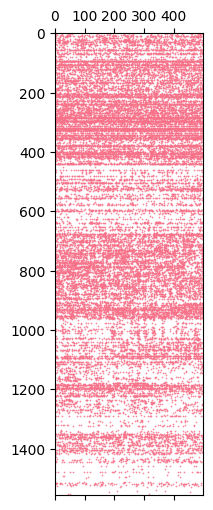

In [230]:
# This should match Image 2:
plt.figure(figsize=(9, 6))
subset = trial_windows[start_trial:end_trial]  # Same range as simple_raster_plot
concatenated = subset.transpose(1, 0, 2).reshape(subset.shape[1], -1)
plt.spy(concatenated,  markersize=0.3, alpha=0.8)
concatenated.sum()
# plt.plot(amplitudes.cpu().T)

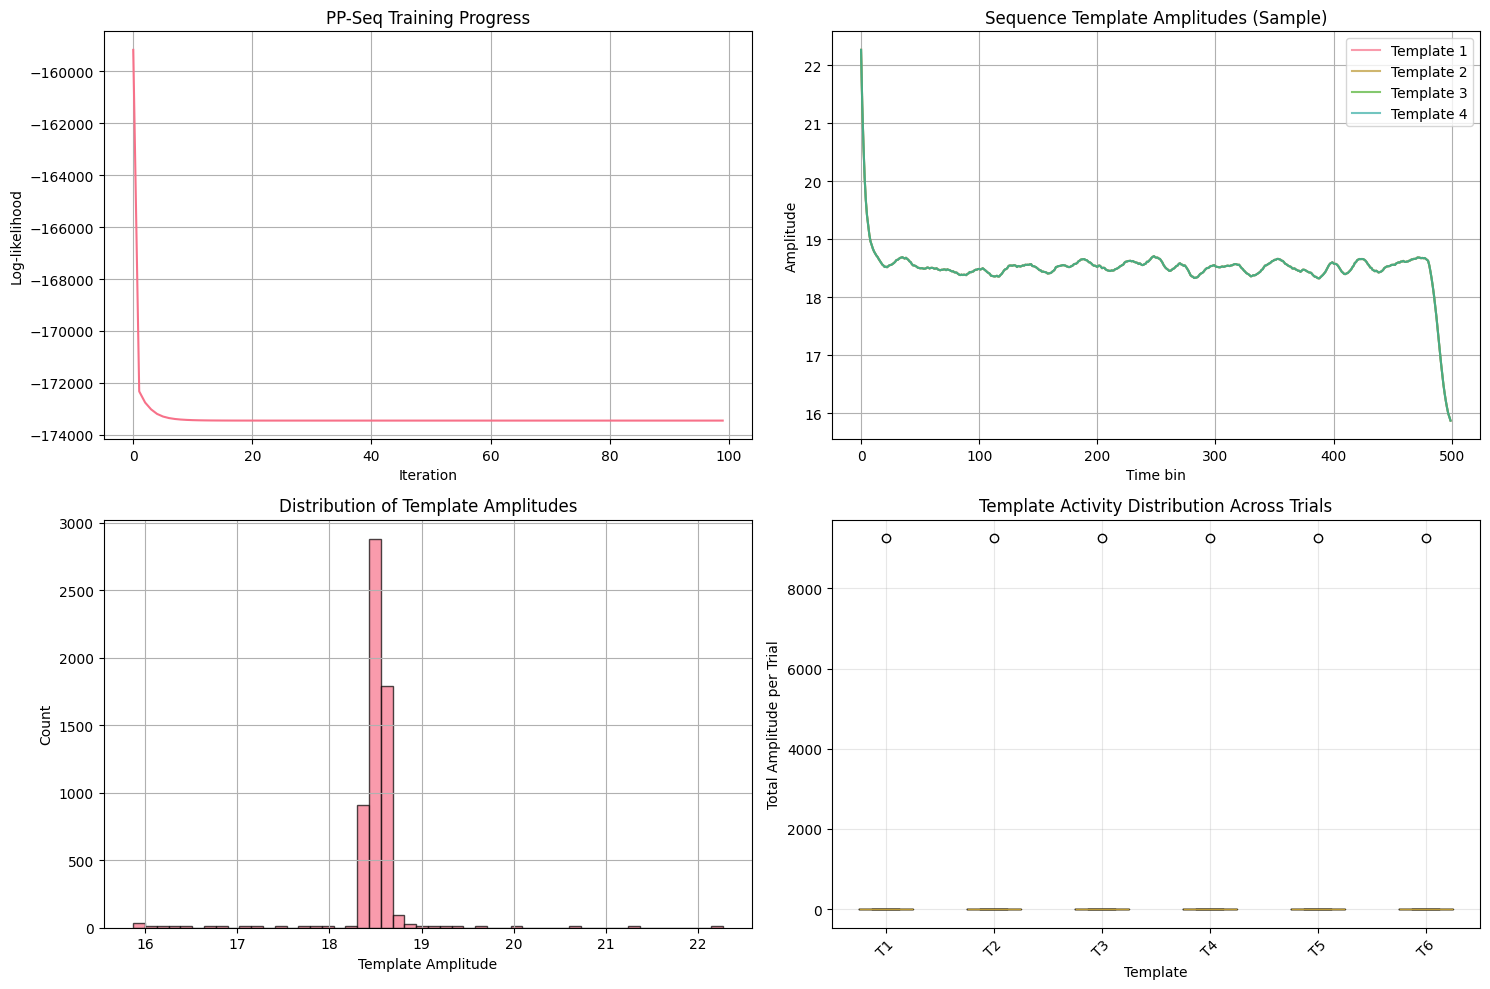


PP-SEQ SEQUENCE DETECTION COMPLETE
✓ Model trained on 200 trials
✓ Detected 12 sequence types
✓ Template duration: 20 bins (100ms)

Sequence Template Activity:
  Template 1: total=9250.4, mean=18.501, peak=22.267
  Template 2: total=9250.4, mean=18.501, peak=22.267
  Template 3: total=9250.4, mean=18.501, peak=22.267
  Template 4: total=9250.4, mean=18.501, peak=22.267
  Template 5: total=9250.4, mean=18.501, peak=22.267
  Template 6: total=9250.4, mean=18.501, peak=22.267
  Template 7: total=9250.4, mean=18.501, peak=22.267
  Template 8: total=9250.4, mean=18.501, peak=22.267
  Template 9: total=9250.4, mean=18.501, peak=22.267
  Template 10: total=9250.4, mean=18.501, peak=22.267
  Template 11: total=9250.4, mean=18.501, peak=22.267
  Template 12: total=9250.4, mean=18.501, peak=22.267

Model Statistics:
  Total amplitude: 111004.6
  Active timepoints: 6,000 (100.0% of total)
  Average amplitude: 18.5008

Data ready for functional classification!

✅ Results saved for functional clas

In [231]:
#%% Fixed Visualization and Summary

import matplotlib.pyplot as plt
import numpy as np

def plot_ppseq_results_fixed(model, amplitudes, log_likelihoods, trial_windows, n_trials_subset):
    """Plot PP-Seq training results and detected sequences - no sequence_df dependency"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Training progress
    axes[0,0].plot(log_likelihoods)
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Log-likelihood')
    axes[0,0].set_title('PP-Seq Training Progress')
    axes[0,0].grid(True)
    
    # Plot 2: Template amplitudes over time (sample)
    sample_length = min(1000, amplitudes.shape[1])
    sample_amps = amplitudes[:, :sample_length]
    
    for i in range(min(4, model.num_templates)):
        axes[0,1].plot(sample_amps[i, :], label=f'Template {i+1}', alpha=0.7)
    axes[0,1].set_xlabel('Time bin')
    axes[0,1].set_ylabel('Amplitude')
    axes[0,1].set_title('Sequence Template Amplitudes (Sample)')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot 3: Template amplitude distributions
    all_amps = amplitudes.flatten()
    non_zero_amps = all_amps[all_amps > 0.01]  # Only significant amplitudes
    
    axes[1,0].hist(non_zero_amps, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Template Amplitude')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Distribution of Template Amplitudes')
    axes[1,0].grid(True)
    
    # Plot 4: Template activity per trial
    window_size = trial_windows.shape[2]
    trial_activity = []
    
    for trial_idx in range(n_trials_subset):
        start_idx = trial_idx * window_size
        end_idx = (trial_idx + 1) * window_size
        trial_amps = amplitudes[:, start_idx:end_idx]
        
        # Total activity per template for this trial
        template_totals = np.sum(trial_amps, axis=1)
        trial_activity.append(template_totals)
    
    trial_activity = np.array(trial_activity)  # (trials, templates)
    
    # Box plot of template activity across trials
    template_data = [trial_activity[:, i] for i in range(min(6, model.num_templates))]
    box_plot = axes[1,1].boxplot(template_data, labels=[f'T{i+1}' for i in range(len(template_data))])
    axes[1,1].set_ylabel('Total Amplitude per Trial')
    axes[1,1].set_xlabel('Template')
    axes[1,1].set_title('Template Activity Distribution Across Trials')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_ppseq_summary_fixed(model, amplitudes, trial_windows, n_trials_subset):
    """Print summary without sequence_df dependency"""
    
    print("\n" + "="*60)
    print("PP-SEQ SEQUENCE DETECTION COMPLETE")
    print("="*60)
    
    print(f"✓ Model trained on {n_trials_subset} trials")
    print(f"✓ Detected {model.num_templates} sequence types")
    print(f"✓ Template duration: {model.template_duration} bins ({model.template_duration * 5}ms)")
    
    # Calculate template statistics from amplitudes directly
    window_size = trial_windows.shape[2]
    template_stats = []
    
    for template_idx in range(model.num_templates):
        template_amps = amplitudes[template_idx, :]
        total_amp = np.sum(template_amps)
        mean_amp = np.mean(template_amps)
        peak_amp = np.max(template_amps)
        
        template_stats.append({
            'total': total_amp,
            'mean': mean_amp, 
            'peak': peak_amp
        })
    
    print(f"\nSequence Template Activity:")
    for i, stats in enumerate(template_stats):
        print(f"  Template {i+1}: total={stats['total']:.1f}, mean={stats['mean']:.3f}, peak={stats['peak']:.3f}")
    
    # Overall model statistics
    total_amplitude = np.sum(amplitudes)
    active_timepoints = np.sum(amplitudes > 0.01)
    sparsity = active_timepoints / amplitudes.size
    
    print(f"\nModel Statistics:")
    print(f"  Total amplitude: {total_amplitude:.1f}")
    print(f"  Active timepoints: {active_timepoints:,} ({sparsity*100:.1f}% of total)")
    print(f"  Average amplitude: {np.mean(amplitudes):.4f}")
    
    print(f"\nData ready for functional classification!")
    return template_stats

# Fixed plotting and summary
plot_fig = plot_ppseq_results_fixed(model, amplitudes.cpu().numpy(), 
                                   log_likelihoods.cpu().numpy(), 
                                   trial_windows, n_trials_subset)

template_stats = print_ppseq_summary_fixed(model, amplitudes.cpu().numpy(), 
                                          trial_windows, n_trials_subset)

# Save key results for next phase (without sequence_df)
results = {
    'model': model,
    'amplitudes': amplitudes,
    'enhanced_matrix': enhanced_matrix,  # Use the enhanced features instead
    'enhanced_feature_names': enhanced_feature_names,
    'trial_windows': trial_windows[start_trial:end_trial],
    'trial_labels': trial_labels[start_trial:end_trial],
    'template_stats': template_stats,
    'config': {
        'num_templates': model.num_templates,
        'n_trials_used': end_trial - start_trial,
        'window_ms': [-500, 2000],
        'bin_ms': 5
    }
}

print(f"\n✅ Results saved for functional classification phase")
print("Ready for decoding analysis with enhanced temporal features!")

Creating diagnostic visualizations...


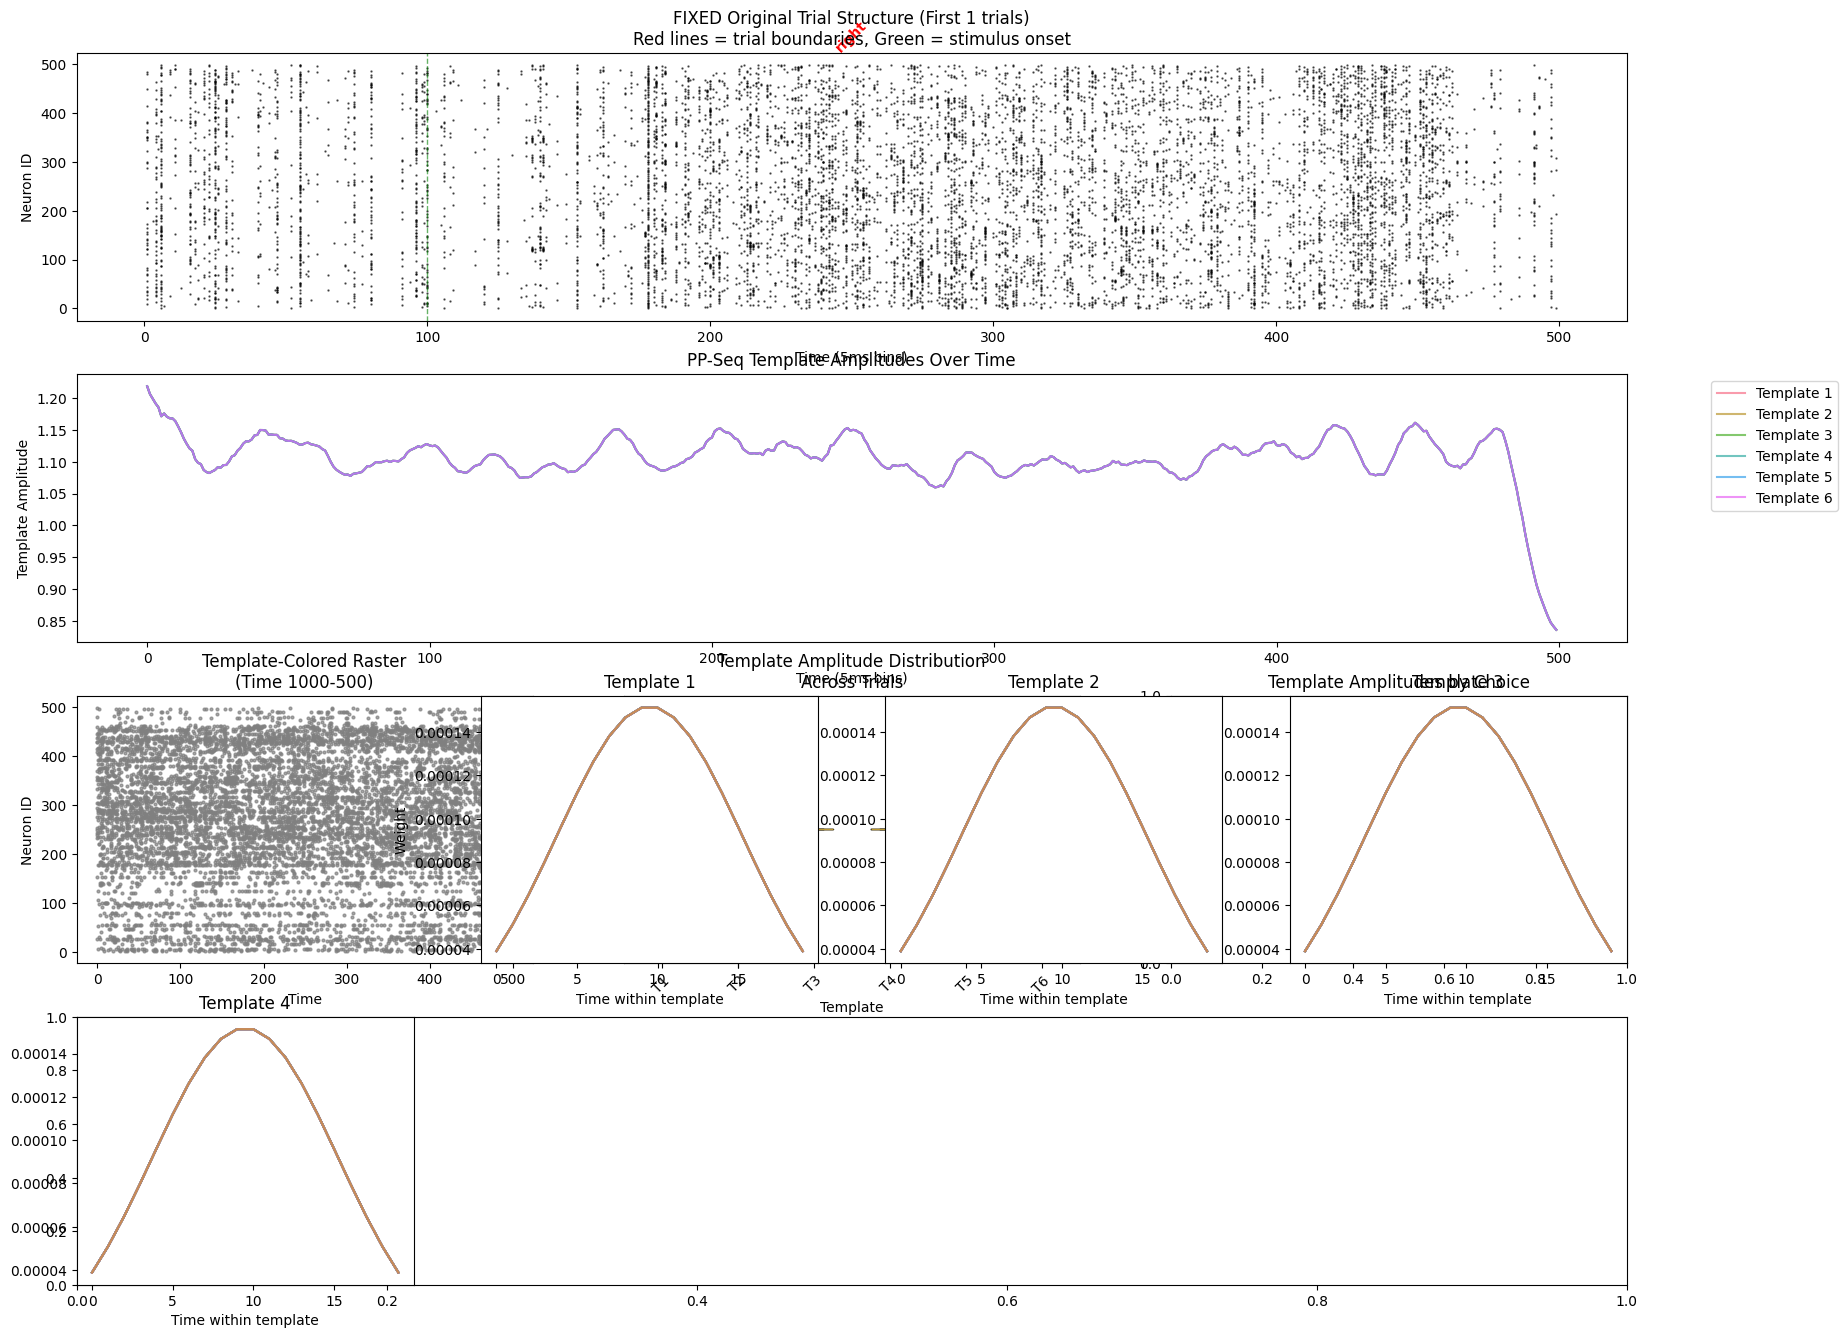


PP-SEQ DIAGNOSTIC STATISTICS

📊 DATA STATISTICS:
  Total neurons: 1557
  Trials used: 1
  Bins per trial: 500
  Total spikes in data: 27674.0
  Average spikes per trial: 27674.0

🧠 MODEL STATISTICS:
  Number of templates: 12
  Template duration: 20 bins
  Total amplitude across all templates: 6631.1
  Template 1 total amplitude: 552.6 (8.3%)
  Template 2 total amplitude: 552.6 (8.3%)
  Template 3 total amplitude: 552.6 (8.3%)
  Template 4 total amplitude: 552.6 (8.3%)
  Template 5 total amplitude: 552.6 (8.3%)
  Template 6 total amplitude: 552.6 (8.3%)
  Template 7 total amplitude: 552.6 (8.3%)
  Template 8 total amplitude: 552.6 (8.3%)
  Template 9 total amplitude: 552.6 (8.3%)
  Template 10 total amplitude: 552.6 (8.3%)
  Template 11 total amplitude: 552.6 (8.3%)
  Template 12 total amplitude: 552.6 (8.3%)

⚖️  CHOICE DISTRIBUTION:
  left: 1 trials (100.0%)

📈 AMPLITUDE VARIATION:
  Template 1: mean=552.59, std=nan, CV=nan
  Template 2: mean=552.59, std=nan, CV=nan
  Template 3: mea

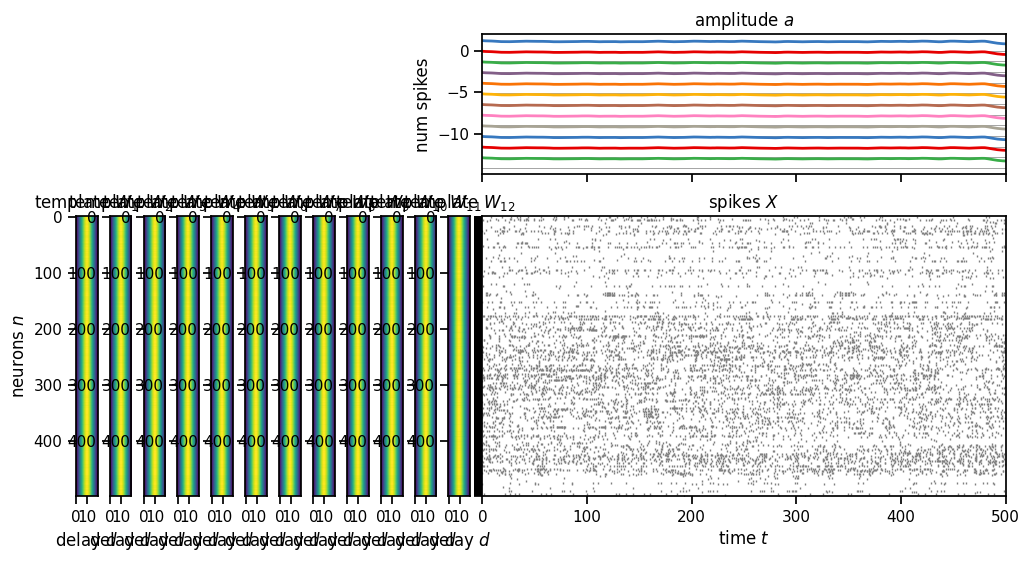


✅ Diagnostic visualization complete!

💡 INTERPRETATION TIPS:
  - If template amplitudes are similar across choices → sequences aren't task-related
  - If templates have low variation (CV) → they might be noise
  - Check if trial boundaries align with sequence events
  - Look for temporal structure in the colored raster plot


In [286]:
#%% Comprehensive PP-Seq Diagnostic Visualization

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from ppseq.plotting import plot_model, sort_neurons
import seaborn as sns

def plot_trial_structure_and_sequences(trial_windows, torch_data, model, amplitudes, trial_labels, n_trials_subset):
    """
    FIXED: Create comprehensive diagnostic plots to understand PP-Seq results
    """
    
    fig = plt.figure(figsize=(20, 16))
    
    # Parameters
    n_neurons, total_time = torch_data.shape
    window_size = trial_windows.shape[2]  # bins per trial
    
    # === 1. FIXED Original Trial Structure ===
    ax1 = plt.subplot(4, 3, (1, 3))
    
    n_show_trials = min(10, n_trials_subset)
    
    # Plot each trial separately with proper time axis
    all_spike_times = []
    all_spike_neurons = []
    
    for trial_idx in range(n_show_trials):
        trial_data = trial_windows[trial_idx]  # (n_neurons, n_bins)
        
        # Find spikes in this trial
        spike_times_bin, spike_neurons = np.where(trial_data > 0)
        
        # Convert to proper time coordinates: trial_offset + time_within_trial
        trial_start_time = trial_idx * window_size
        spike_times_plot = trial_start_time + spike_times_bin
        
        all_spike_times.extend(spike_times_plot)
        all_spike_neurons.extend(spike_neurons)
    
    # Plot all spikes with correct time coordinates
    ax1.scatter(all_spike_times, all_spike_neurons, s=0.5, alpha=0.6, c='black')
    
    # Add trial boundaries at correct positions
    for trial_idx in range(1, n_show_trials):
        boundary_pos = trial_idx * window_size
        ax1.axvline(x=boundary_pos, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add stimulus onset markers (bin 100 within each trial)
    for trial_idx in range(n_show_trials):
        stim_pos = trial_idx * window_size + 100  # bin 100 = stimulus onset
        ax1.axvline(x=stim_pos, color='green', linestyle='--', alpha=0.6, linewidth=1)
    
    ax1.set_ylabel('Neuron ID')
    ax1.set_xlabel('Time (5ms bins)')
    ax1.set_title(f'FIXED Original Trial Structure (First {n_show_trials} trials)\nRed lines = trial boundaries, Green = stimulus onset')
    
    # Add trial labels
    for trial_idx in range(n_show_trials):
        if trial_idx < len(trial_labels):
            choice = trial_labels[trial_idx]['choice']
            x_pos = trial_idx * window_size + window_size/2
            ax1.text(x_pos, n_neurons + 20, choice, ha='center', va='bottom', 
                    color='red', fontweight='bold', rotation=45)
    
    # === 2. PP-Seq Template Amplitudes Over Time ===
    ax2 = plt.subplot(4, 3, (4, 6))
    
    # Show amplitudes for a subset of time
    time_subset = slice(0, min(5000, total_time))
    amp_subset = amplitudes[:, time_subset].cpu().numpy()
    
    for template_idx in range(min(6, model.num_templates)):
        ax2.plot(amp_subset[template_idx, :], label=f'Template {template_idx+1}', alpha=0.7)
    
    # Add trial boundaries for the subset
    trials_in_subset = min(5000 // window_size, n_show_trials) 
    for trial_idx in range(1, trials_in_subset):
        boundary_pos = trial_idx * window_size
        if boundary_pos < amp_subset.shape[1]:
            ax2.axvline(x=boundary_pos, color='red', linestyle='--', alpha=0.7)
    
    ax2.set_ylabel('Template Amplitude')
    ax2.set_xlabel('Time (5ms bins)')
    ax2.set_title('PP-Seq Template Amplitudes Over Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === 3. Template-Colored Raster (Zoomed) ===
    ax3 = plt.subplot(4, 3, 7)
    
    # Focus on a specific region with activity
    start_time = 1000
    end_time = min(start_time + 2000, total_time)

    # data_subset = torch_data[:, start_time:end_time].cpu().numpy()
    data_subset  = torch_data.cpu()
    amp_subset = amplitudes.cpu()
    # amp_subset = amplitudes[:, start_time:end_time].cpu()
    
    # Get template assignments for each spike
    b = model.base_rates.cpu()
    W = model.templates.cpu()
    N, T = data_subset.shape
    K = W.shape[0]
    D = W.shape[2]
    
    black_nt = b.view(N, 1).expand(N, T)
    template_responses = []
    
    for i in range(K):
        template_response = F.conv1d(amp_subset[[i], :], torch.flip(W[[i]].permute(1, 0, 2), [2]), padding=D-1)[:, :-D+1]
        template_responses.append(template_response)
    
    matrices = torch.stack([black_nt] + template_responses)
    
    # Assign colors
    colors = np.full((T, N), -1)
    color_names = ['Background', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
    color_map = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown']
    
    for t in range(T):
        for n in range(N):
            if data_subset[n, t] > 0:
                colors[t, n] = torch.argmax(matrices[:, n, t]).item()
    
    # Plot colored spikes
    for color_idx in range(min(7, K+1)):
        spike_coords = np.argwhere(colors == color_idx)
        if len(spike_coords) > 0:
            ax3.scatter(spike_coords[:, 0], spike_coords[:, 1], 
                       c=color_map[color_idx], s=4, alpha=0.7, 
                       label=color_names[color_idx])
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Neuron ID')
    ax3.set_title(f'Template-Colored Raster\n(Time {start_time}-{end_time})')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === 4. Sequence Amplitude Statistics ===
    ax4 = plt.subplot(4, 3, 8)
    
    # Calculate amplitude statistics per trial
    trial_amplitudes = []
    for trial_idx in range(n_trials_subset):
        start_idx = trial_idx * window_size
        end_idx = (trial_idx + 1) * window_size
        trial_amps = amplitudes[:, start_idx:end_idx].cpu().numpy()
        
        # Total amplitude per template for this trial
        trial_totals = np.sum(trial_amps, axis=1)
        trial_amplitudes.append(trial_totals)
    
    trial_amplitudes = np.array(trial_amplitudes)  # (trials, templates)
    
    # Box plot of amplitudes across trials
    ax4.boxplot([trial_amplitudes[:, i] for i in range(min(6, model.num_templates))], 
                labels=[f'T{i+1}' for i in range(min(6, model.num_templates))])
    ax4.set_ylabel('Total Amplitude per Trial')
    ax4.set_xlabel('Template')
    ax4.set_title('Template Amplitude Distribution\nAcross Trials')
    ax4.tick_params(axis='x', rotation=45)
    
    # === 5. Choice-based Amplitude Comparison ===
    ax5 = plt.subplot(4, 3, 9)
    
    # Separate by choice
    left_trials = []
    right_trials = []
    
    for trial_idx in range(min(len(trial_labels), n_trials_subset)):
        if trial_labels[trial_idx]['choice'] == 'left':
            left_trials.append(trial_amplitudes[trial_idx])
        else:
            right_trials.append(trial_amplitudes[trial_idx])
    
    if left_trials and right_trials:
        left_trials = np.array(left_trials)
        right_trials = np.array(right_trials)
        
        # Plot mean amplitudes by choice
        templates_to_show = min(6, model.num_templates)
        x = np.arange(templates_to_show)
        width = 0.35
        
        left_means = np.mean(left_trials[:, :templates_to_show], axis=0)
        right_means = np.mean(right_trials[:, :templates_to_show], axis=0)
        left_stds = np.std(left_trials[:, :templates_to_show], axis=0)
        right_stds = np.std(right_trials[:, :templates_to_show], axis=0)
        
        ax5.bar(x - width/2, left_means, width, yerr=left_stds, 
                label='Left Choice', alpha=0.7, capsize=5)
        ax5.bar(x + width/2, right_means, width, yerr=right_stds, 
                label='Right Choice', alpha=0.7, capsize=5)
        
        ax5.set_ylabel('Mean Amplitude')
        ax5.set_xlabel('Template')
        ax5.set_title('Template Amplitudes by Choice')
        ax5.set_xticks(x)
        ax5.set_xticklabels([f'T{i+1}' for i in range(templates_to_show)])
        ax5.legend()
    else:
        ax5.text(0.5, 0.5, 'Insufficient choice data', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Template Amplitudes by Choice')
    
    # === 6. Model Templates Visualization ===
    ax6 = plt.subplot(4, 3, (10, 12))
    
    # Show the learned templates
    templates = model.templates.cpu().numpy()  # (num_templates, num_neurons, template_duration)
    
    # Plot first few templates
    templates_to_plot = min(4, model.num_templates)
    for i in range(templates_to_plot):
        template = templates[i]  # (num_neurons, template_duration)
        
        # Find neurons with significant activity
        max_vals = np.max(template, axis=1)
        active_neurons = np.where(max_vals > np.percentile(max_vals, 90))[0]
        
        if len(active_neurons) > 0:
            # Plot template for active neurons
            ax_sub = plt.subplot(4, templates_to_plot, 9 + i + 1)
            
            for j, neuron_idx in enumerate(active_neurons[:20]):  # Show top 20 active neurons
                ax_sub.plot(template[neuron_idx], alpha=0.7, label=f'N{neuron_idx}' if j < 5 else '')
            
            ax_sub.set_title(f'Template {i+1}')
            ax_sub.set_xlabel('Time within template')
            if i == 0:
                ax_sub.set_ylabel('Weight')
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
    # === 2. PP-Seq Template Amplitudes Over Time ===
    ax2 = plt.subplot(4, 3, (4, 6))
    
    # Show amplitudes for a subset of time
    time_subset = slice(0, min(5000, total_time))
    amp_subset = amplitudes#[:, time_subset].cpu().numpy()
    
    for template_idx in range(min(6, model.num_templates)):
        ax2.plot(amp_subset[template_idx, :], label=f'Template {template_idx+1}', alpha=0.7)
    
    # Add trial boundaries for the subset
    trials_in_subset = min(5000 // window_size, n_show_trials)
    for trial_idx in range(1, trials_in_subset):
        boundary_pos = trial_idx * window_size
        if boundary_pos < amp_subset.shape[1]:
            ax2.axvline(x=boundary_pos, color='red', linestyle='--', alpha=0.7)
    
    ax2.set_ylabel('Template Amplitude')
    ax2.set_xlabel('Time (5ms bins)')
    ax2.set_title('PP-Seq Template Amplitudes Over Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === 3. Template-Colored Raster (Zoomed) ===
    ax3 = plt.subplot(4, 3, 7)
    
    # Focus on a specific region with activity
    start_time = 1000
    end_time = min(start_time + 2000, total_time)
    
    data_subset = torch_data[:, start_time:end_time].cpu().numpy()
    amp_subset = amplitudes[:, start_time:end_time].cpu()
    
    # Get template assignments for each spike
    b = model.base_rates.cpu()
    W = model.templates.cpu()
    N, T = data_subset.shape
    K = W.shape[0]
    D = W.shape[2]
    
    black_nt = b.view(N, 1).expand(N, T)
    template_responses = []
    
    for i in range(K):
        template_response = F.conv1d(amp_subset[[i], :], torch.flip(W[[i]].permute(1, 0, 2), [2]), padding=D-1)[:, :-D+1]
        template_responses.append(template_response)
    
    matrices = torch.stack([black_nt] + template_responses)
    
    # Assign colors
    colors = np.full((T, N), -1)
    color_names = ['Background', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
    color_map = ['gray', 'red', 'blue', 'green', 'purple', 'orange', 'brown']
    
    for t in range(T):
        for n in range(N):
            if data_subset[n, t] > 0:
                colors[t, n] = torch.argmax(matrices[:, n, t]).item()
    
    # Plot colored spikes
    for color_idx in range(min(7, K+1)):
        spike_coords = np.argwhere(colors == color_idx)
        if len(spike_coords) > 0:
            ax3.scatter(spike_coords[:, 0], spike_coords[:, 1], 
                       c=color_map[color_idx], s=4, alpha=0.7, 
                       label=color_names[color_idx])
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Neuron ID')
    ax3.set_title(f'Template-Colored Raster\n(Time {start_time}-{end_time})')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === 4. Sequence Amplitude Statistics ===
    ax4 = plt.subplot(4, 3, 8)
    
    # Calculate amplitude statistics per trial
    trial_amplitudes = []
    for trial_idx in range(n_trials_subset):
        start_idx = trial_idx * window_size
        end_idx = (trial_idx + 1) * window_size
        trial_amps = amplitudes[:, start_idx:end_idx].cpu().numpy()
        
        # Total amplitude per template for this trial
        trial_totals = np.sum(trial_amps, axis=1)
        trial_amplitudes.append(trial_totals)
    
    trial_amplitudes = np.array(trial_amplitudes)  # (trials, templates)
    
    # Box plot of amplitudes across trials
    ax4.boxplot([trial_amplitudes[:, i] for i in range(min(6, model.num_templates))], 
                labels=[f'T{i+1}' for i in range(min(6, model.num_templates))])
    ax4.set_ylabel('Total Amplitude per Trial')
    ax4.set_xlabel('Template')
    ax4.set_title('Template Amplitude Distribution\nAcross Trials')
    ax4.tick_params(axis='x', rotation=45)
    
    # === 5. Choice-based Amplitude Comparison ===
    ax5 = plt.subplot(4, 3, 9)
    
    # Separate by choice
    left_trials = []
    right_trials = []
    
    for trial_idx in range(min(len(trial_labels), n_trials_subset)):
        if trial_labels[trial_idx]['choice'] == 'left':
            left_trials.append(trial_amplitudes[trial_idx])
        else:
            right_trials.append(trial_amplitudes[trial_idx])
    
    if left_trials and right_trials:
        left_trials = np.array(left_trials)
        right_trials = np.array(right_trials)
        
        # Plot mean amplitudes by choice
        templates_to_show = min(6, model.num_templates)
        x = np.arange(templates_to_show)
        width = 0.35
        
        left_means = np.mean(left_trials[:, :templates_to_show], axis=0)
        right_means = np.mean(right_trials[:, :templates_to_show], axis=0)
        left_stds = np.std(left_trials[:, :templates_to_show], axis=0)
        right_stds = np.std(right_trials[:, :templates_to_show], axis=0)
        
        ax5.bar(x - width/2, left_means, width, yerr=left_stds, 
                label='Left Choice', alpha=0.7, capsize=5)
        ax5.bar(x + width/2, right_means, width, yerr=right_stds, 
                label='Right Choice', alpha=0.7, capsize=5)
        
        ax5.set_ylabel('Mean Amplitude')
        ax5.set_xlabel('Template')
        ax5.set_title('Template Amplitudes by Choice')
        ax5.set_xticks(x)
        ax5.set_xticklabels([f'T{i+1}' for i in range(templates_to_show)])
        ax5.legend()
    else:
        ax5.text(0.5, 0.5, 'Insufficient choice data', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Template Amplitudes by Choice')
    
    # === 6. Model Templates Visualization ===
    ax6 = plt.subplot(4, 3, (10, 12))
    
    # Show the learned templates
    templates = model.templates.cpu().numpy()  # (num_templates, num_neurons, template_duration)
    
    # Plot first few templates
    templates_to_plot = min(4, model.num_templates)
    for i in range(templates_to_plot):
        template = templates[i]  # (num_neurons, template_duration)
        
        # Find neurons with significant activity
        max_vals = np.max(template, axis=1)
        active_neurons = np.where(max_vals > np.percentile(max_vals, 90))[0]
        
        if len(active_neurons) > 0:
            # Plot template for active neurons
            ax_sub = plt.subplot(4, templates_to_plot, 9 + i + 1)
            
            for j, neuron_idx in enumerate(active_neurons[:20]):  # Show top 20 active neurons
                ax_sub.plot(template[neuron_idx], alpha=0.7, label=f'N{neuron_idx}' if j < 5 else '')
            
            ax_sub.set_title(f'Template {i+1}')
            ax_sub.set_xlabel('Time within template')
            if i == 0:
                ax_sub.set_ylabel('Weight')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# === Diagnostic Statistics ===
def print_diagnostic_stats(trial_windows, model, amplitudes, trial_labels, n_trials_subset):
    """Print diagnostic statistics to understand the data and model"""
    
    print("\n" + "="*60)
    print("PP-SEQ DIAGNOSTIC STATISTICS")
    print("="*60)
    
    # Data statistics
    print(f"\n📊 DATA STATISTICS:")
    print(f"  Total neurons: {trial_windows.shape[1]}")
    print(f"  Trials used: {n_trials_subset}")
    print(f"  Bins per trial: {trial_windows.shape[2]}")
    print(f"  Total spikes in data: {np.sum(trial_windows[:n_trials_subset])}")
    print(f"  Average spikes per trial: {np.sum(trial_windows[:n_trials_subset]) / n_trials_subset:.1f}")
    
    # Model statistics
    print(f"\n🧠 MODEL STATISTICS:")
    print(f"  Number of templates: {model.num_templates}")
    print(f"  Template duration: {model.template_duration} bins")
    
    # Template activity statistics
    total_amp = torch.sum(amplitudes).item()
    print(f"  Total amplitude across all templates: {total_amp:.1f}")
    
    template_totals = torch.sum(amplitudes, dim=1)
    for i, total in enumerate(template_totals):
        print(f"  Template {i+1} total amplitude: {total:.1f} ({total/total_amp*100:.1f}%)")
    
    # Choice distribution
    if trial_labels:
        choices = [trial['choice'] for trial in trial_labels[:n_trials_subset]]
        choice_counts = {choice: choices.count(choice) for choice in set(choices)}
        print(f"\n⚖️  CHOICE DISTRIBUTION:")
        for choice, count in choice_counts.items():
            print(f"  {choice}: {count} trials ({count/len(choices)*100:.1f}%)")
    
    # Amplitude variation analysis
    window_size = trial_windows.shape[2]
    trial_amplitudes = []
    for trial_idx in range(n_trials_subset):
        start_idx = trial_idx * window_size
        end_idx = (trial_idx + 1) * window_size
        trial_amps = torch.sum(amplitudes[:, start_idx:end_idx], dim=1)
        trial_amplitudes.append(trial_amps)
    
    trial_amplitudes = torch.stack(trial_amplitudes)  # (trials, templates)
    
    print(f"\n📈 AMPLITUDE VARIATION:")
    for i in range(model.num_templates):
        template_amps = trial_amplitudes[:, i]
        mean_amp = torch.mean(template_amps)
        std_amp = torch.std(template_amps)
        cv = std_amp / mean_amp if mean_amp > 0 else 0
        print(f"  Template {i+1}: mean={mean_amp:.2f}, std={std_amp:.2f}, CV={cv:.3f}")

# Run the diagnostic visualization
print("Creating diagnostic visualizations...")
n_trials_subset = end_trial - start_trial
fig = plot_trial_structure_and_sequences(
    trial_windows[start_trial:end_trial, 500:1000], torch_data, model, amplitudes, trial_labels[start_trial:end_trial], n_trials_subset
)

# Print diagnostic statistics
print_diagnostic_stats(trial_windows, model, amplitudes, trial_labels, n_trials_subset)

# === Additional PP-Seq Model Plot ===
print("\nCreating PP-Seq model plot...")
try:
    import importlib
    import ppseq.plotting as plotting
    importlib.reload(plotting)
    from ppseq.plotting import plot_model
    
    fig_model = plot_model(model.templates.cpu(), amplitudes.cpu(), torch_data.cpu())
    plt.show()
    
except ImportError:
    print("⚠️  ppseq.plotting not available for model plot")

print("\n✅ Diagnostic visualization complete!")
print("\n💡 INTERPRETATION TIPS:")
print("  - If template amplitudes are similar across choices → sequences aren't task-related")
print("  - If templates have low variation (CV) → they might be noise")
print("  - Check if trial boundaries align with sequence events")
print("  - Look for temporal structure in the colored raster plot")

In [94]:
#%% Simple Temporal Amplitude Features

import numpy as np
from sklearn.preprocessing import StandardScaler

def create_amplitude_feature_matrix_temporal(model, amplitudes, trial_windows, trial_labels):
    """
    Create feature matrix with basic temporal periods:
    - Total amplitudes + period-specific amplitudes (baseline, early, late, movement)
    """
    print("Creating temporal amplitude feature matrix...")
    
    n_trials = len(trial_windows)
    n_templates = model.num_templates
    window_size = trial_windows.shape[2]
    
    # Define time periods (bin 100 = stimulus onset)
    periods = {
        'baseline': (0, 100),     # -500ms to 0ms
        'early': (100, 200),      # 0ms to +500ms  
        'late': (200, 400),       # +500ms to +1500ms
        'movement': (400, 500)    # +1500ms to +2000ms
    }
    
    all_features = []
    feature_names = []
    
    for trial_idx in range(n_trials):
        trial_features = []
        
        # Extract trial amplitudes
        start_idx = trial_idx * window_size
        end_idx = (trial_idx + 1) * window_size
        trial_amps = amplitudes[:, start_idx:end_idx].cpu().numpy()
        
        # Basic total amplitudes
        for t in range(n_templates):
            trial_features.append(np.sum(trial_amps[t]))
            if trial_idx == 0:
                feature_names.append(f'template_{t}_total')
        
        # Period-specific amplitudes
        for period_name, (start_bin, end_bin) in periods.items():
            for t in range(n_templates):
                period_amp = np.sum(trial_amps[t, start_bin:end_bin])
                trial_features.append(period_amp)
                if trial_idx == 0:
                    feature_names.append(f'template_{t}_{period_name}')
        
        all_features.append(trial_features)
    
    feature_matrix = np.array(all_features)
    
    print(f"✓ Feature matrix shape: {feature_matrix.shape}")
    print(f"✓ Features: {n_templates} total + {len(periods) * n_templates} temporal = {len(feature_names)} total")
    
    # Standardize
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    return feature_matrix_scaled, feature_names, scaler

# Create temporal features
enhanced_matrix, enhanced_feature_names, enhanced_scaler = create_amplitude_feature_matrix_temporal(
    model, amplitudes, trial_windows, trial_labels
)

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (403, 60)
✓ Features: 12 total + 48 temporal = 60 total


In [101]:
#%% Fixed Decoding Analysis

import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

def run_sequence_decoding_analysis_fixed(amplitude_matrix, trial_labels, cv_folds=5):
    """
    FIXED: Run decoding analysis using trial_labels instead of sequence_df
    """
    print("Running multi-variable decoding analysis...")
    
    # Ensure we have the right number of trials
    n_trials = len(amplitude_matrix)
    trial_labels = trial_labels[:n_trials]  # Truncate if needed
    
    print(f"Analyzing {n_trials} trials with {amplitude_matrix.shape[1]} features")
    
    # Prepare task variables for decoding
    task_variables = {}
    
    # 1. Choice direction (left/right)
    choices = [trial['choice'] for trial in trial_labels]
    task_variables['choice'] = np.array(choices)
    print(f"Choice labels: {np.unique(task_variables['choice'])}")
    
    # 2. Movement timing (early vs late reaction times)  
    if 'reaction_time' in trial_labels[0]:
        reaction_times = [trial['reaction_time'] for trial in trial_labels]
        rt_median = np.median(reaction_times)
        movement_timing = ['early' if rt < rt_median else 'late' for rt in reaction_times]
        task_variables['movement_timing'] = np.array(movement_timing)
        print(f"Movement timing (median RT = {rt_median:.3f}s): {np.unique(task_variables['movement_timing'])}")
        
        # 3. Trial difficulty (reaction time tertiles)
        rt_tertiles = np.percentile(reaction_times, [33, 67])
        difficulty = []
        for rt in reaction_times:
            if rt < rt_tertiles[0]:
                difficulty.append('easy')
            elif rt < rt_tertiles[1]:
                difficulty.append('medium') 
            else:
                difficulty.append('hard')
        task_variables['difficulty'] = np.array(difficulty)
        print(f"Difficulty levels: {np.unique(task_variables['difficulty'])}")
    
    # Run decoding for each task variable
    decoding_results = {}
    
    for var_name, labels in task_variables.items():
        print(f"\nDecoding {var_name}...")
        
        # Check if we have enough samples per class
        unique_labels, counts = np.unique(labels, return_counts=True)
        min_count = np.min(counts)
        
        if min_count < cv_folds:
            print(f"  ⚠️  Skipping {var_name}: insufficient samples (min: {min_count})")
            continue
            
        print(f"  Class distribution: {dict(zip(unique_labels, counts))}")
        
        # Cross-validation decoding
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        classifier = LogisticRegression(random_state=42, max_iter=1000)
        
        # Get cross-validation scores
        cv_scores = cross_val_score(classifier, amplitude_matrix, labels, cv=cv, scoring='accuracy')
        
        # Fit full model to get feature weights
        classifier.fit(amplitude_matrix, labels)
        
        # Store results
        decoding_results[var_name] = {
            'cv_scores': cv_scores,
            'mean_accuracy': np.mean(cv_scores),
            'std_accuracy': np.std(cv_scores),
            'feature_weights': classifier.coef_[0] if len(unique_labels) == 2 else classifier.coef_,
            'classes': unique_labels,
            'n_samples': len(labels)
        }
        
        print(f"  ✓ Accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    return decoding_results

# Run FIXED decoding analysis
decoding_results = run_sequence_decoding_analysis_fixed(enhanced_matrix, trial_labels)

print(f"\n✅ Shape check:")
print(f"  enhanced_matrix: {enhanced_matrix.shape}")
print(f"  trial_labels: {len(trial_labels)}")
print(f"  Using: {len(trial_labels[:len(enhanced_matrix)])} trials")

Running multi-variable decoding analysis...
Analyzing 403 trials with 60 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.168s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(247), np.str_('right'): np.int64(156)}
  ✓ Accuracy: 0.551 ± 0.028

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(201), np.str_('late'): np.int64(202)}
  ✓ Accuracy: 0.655 ± 0.075

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(133), np.str_('hard'): np.int64(133), np.str_('medium'): np.int64(137)}
  ✓ Accuracy: 0.432 ± 0.017

✅ Shape check:
  enhanced_matrix: (403, 60)
  trial_labels: 403
  Using: 403 trials


Classifying sequence functions...
Template 1: Task-unrelated (best: movement_timing = 0.655)
Template 2: Task-unrelated (best: movement_timing = 0.655)
Template 3: Task-unrelated (best: movement_timing = 0.655)
Template 4: Task-unrelated (best: movement_timing = 0.655)
Template 5: Task-unrelated (best: movement_timing = 0.655)
Template 6: Task-unrelated (best: movement_timing = 0.655)
Template 7: Task-unrelated (best: movement_timing = 0.655)
Template 8: Task-unrelated (best: movement_timing = 0.655)
Template 9: Task-unrelated (best: movement_timing = 0.655)
Template 10: Task-unrelated (best: movement_timing = 0.655)
Template 11: Task-unrelated (best: movement_timing = 0.655)
Template 12: Task-unrelated (best: movement_timing = 0.655)


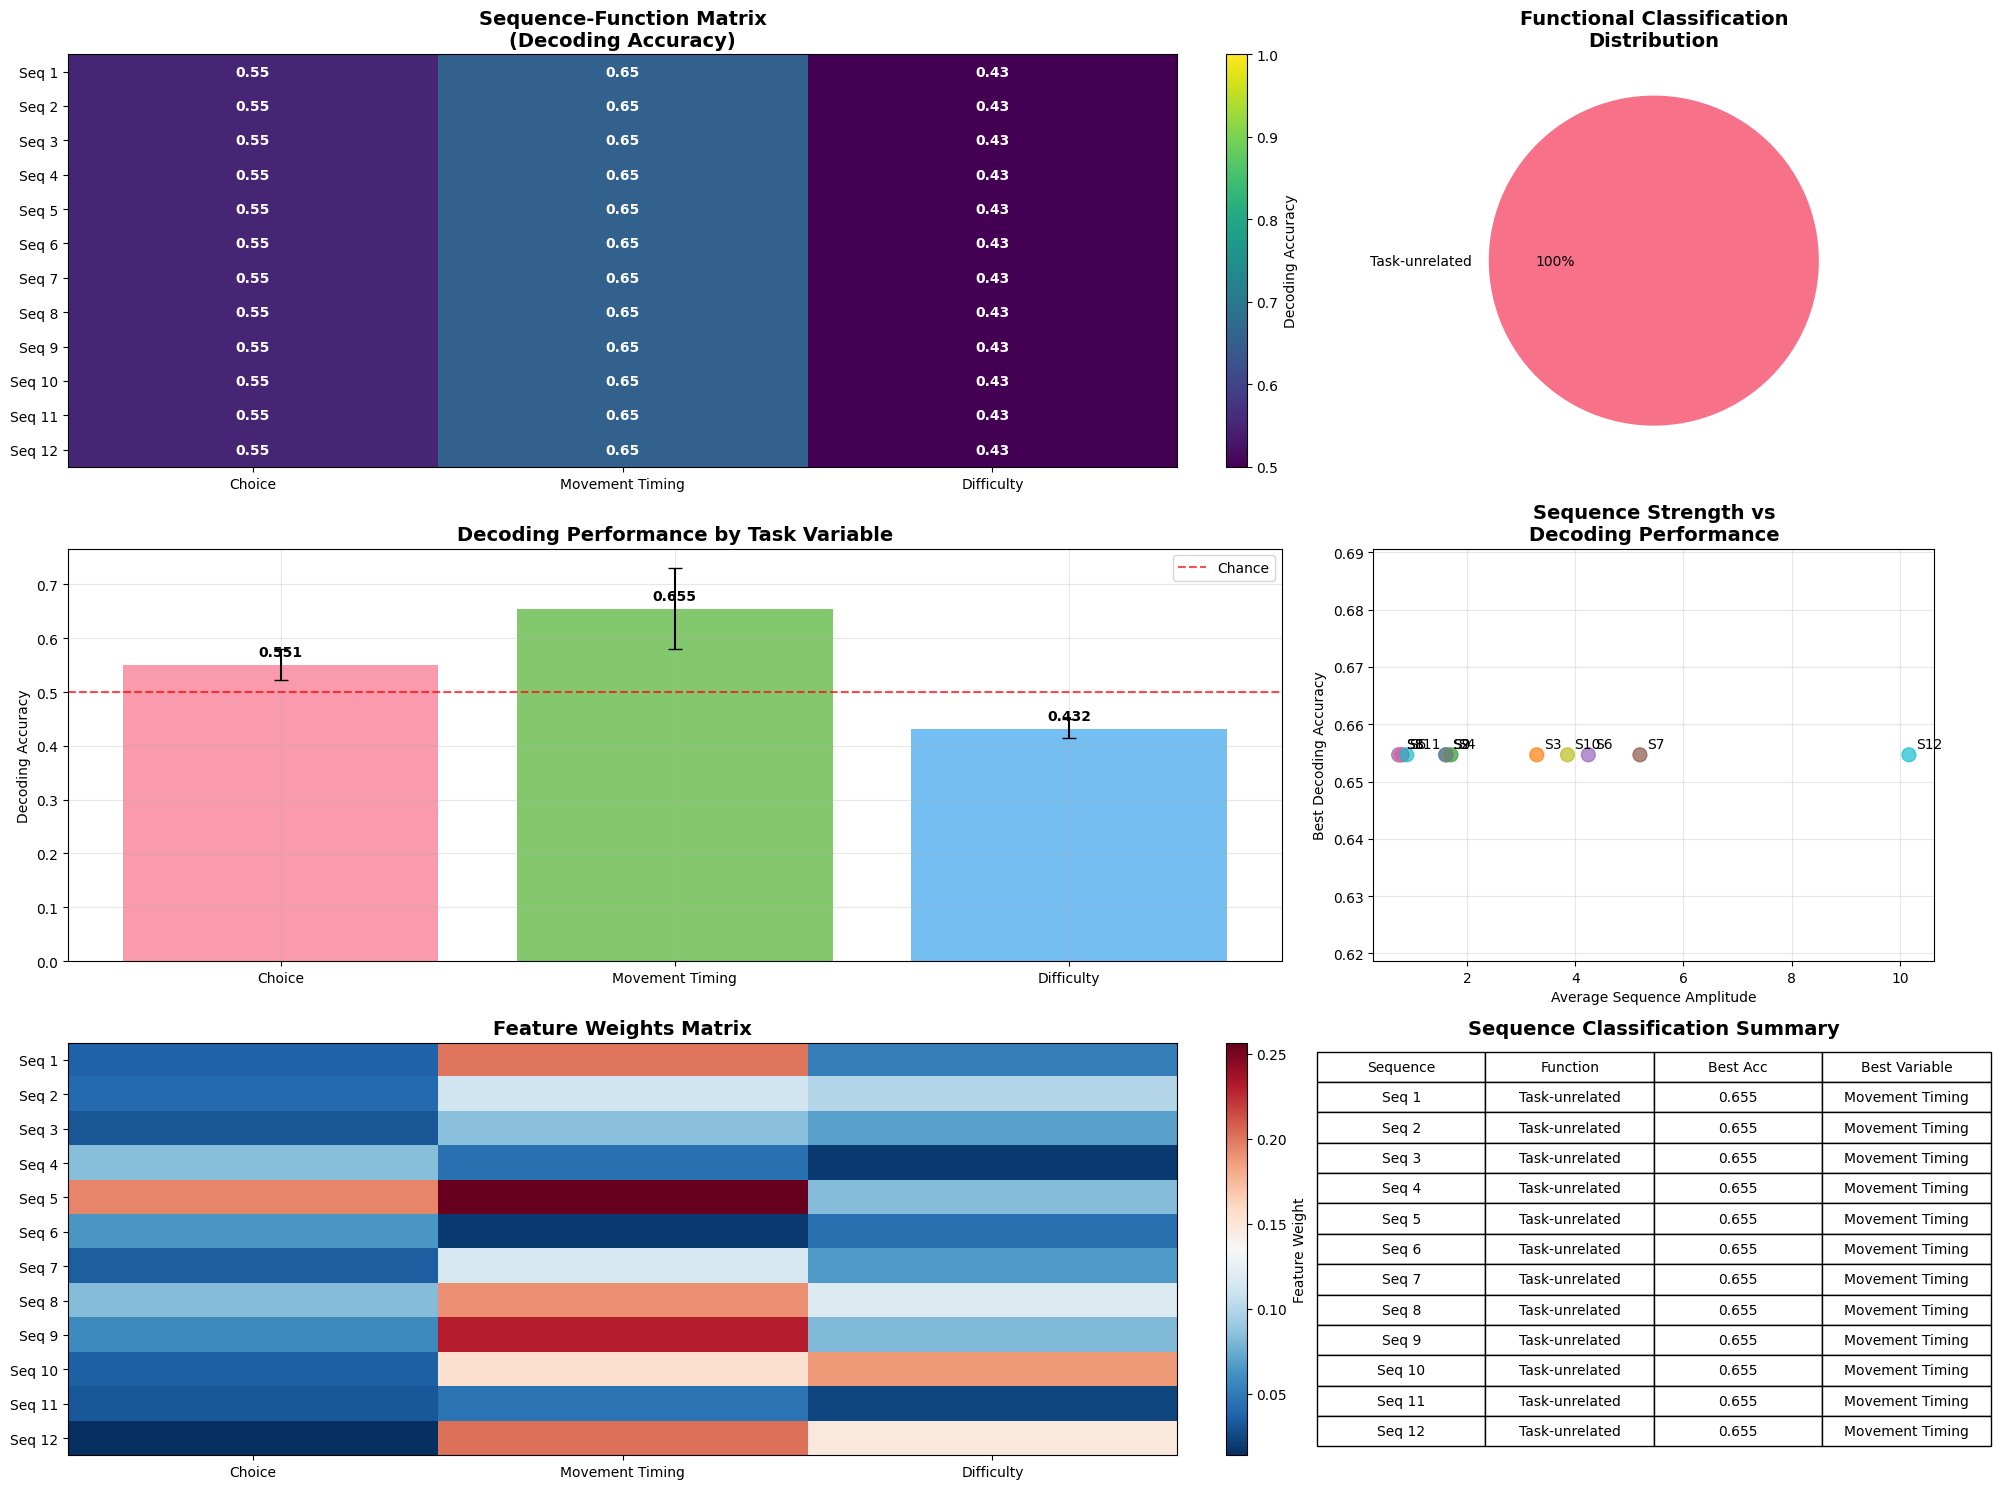


FUNCTIONAL CLASSIFICATION COMPLETE

📊 DECODING PERFORMANCE SUMMARY:
  Choice: 0.551 ± 0.028
  Movement Timing: 0.655 ± 0.075
  Difficulty: 0.432 ± 0.017

🧠 SEQUENCE FUNCTIONAL CLASSIFICATION:
  Task-unrelated: 12 sequences

🏆 TOP PERFORMING SEQUENCES:
  Template 1: Task-unrelated (acc=0.655, movement_timing)
  Template 2: Task-unrelated (acc=0.655, movement_timing)
  Template 3: Task-unrelated (acc=0.655, movement_timing)
  Template 4: Task-unrelated (acc=0.655, movement_timing)
  Template 5: Task-unrelated (acc=0.655, movement_timing)

✓ Results saved for brain-wide mapping phase


In [103]:


#%% Functional Classification of Sequences

def classify_sequence_functions(decoding_results, sequence_columns, threshold_high=0.7, threshold_multi=0.6):
    """
    Classify each sequence type functionally based on decoding accuracies:
    
    Functional classification:
        If stimulus decoding > 0.7: "Visual processing sequence"
        If choice decoding > 0.7: "Decision formation sequence"  
        If movement decoding > 0.7: "Motor execution sequence"
        If multiple > 0.6: "Multi-modal sequence"
        If all < 0.6: "Task-unrelated sequence"
    """
    print("Classifying sequence functions...")
    
    n_sequences = len(sequence_columns)
    sequence_classifications = []
    
    for seq_idx in range(n_sequences):
        seq_name = sequence_columns[seq_idx]
        template_num = seq_idx + 1
        
        # Get decoding performance for this sequence
        seq_performance = {}
        seq_weights = {}
        
        for var_name, results in decoding_results.items():
            accuracy = results['mean_accuracy']
            
            # Get feature weight for this sequence
            if len(results['feature_weights'].shape) == 1:  # Binary classification
                weight = abs(results['feature_weights'][seq_idx])
            else:  # Multi-class
                weight = np.mean(np.abs(results['feature_weights'][:, seq_idx]))
            
            seq_performance[var_name] = accuracy
            seq_weights[var_name] = weight
        
        # Determine functional classification
        best_variable = max(seq_performance.keys(), key=lambda k: seq_performance[k]) if seq_performance else None
        best_accuracy = seq_performance[best_variable] if best_variable else 0
        
        # Count variables above multi-modal threshold
        high_performance_vars = [var for var, acc in seq_performance.items() if acc > threshold_multi]
        
        # Classify function
        if best_accuracy > threshold_high:
            if best_variable == 'stimulus':
                function_type = "Visual processing"
            elif best_variable == 'choice':
                function_type = "Decision formation"
            elif best_variable == 'movement_timing':
                function_type = "Motor execution"
            elif best_variable == 'difficulty':
                function_type = "Difficulty encoding"
            else:
                function_type = f"{best_variable.title()} processing"
        elif len(high_performance_vars) > 1:
            function_type = "Multi-modal"
        else:
            function_type = "Task-unrelated"
        
        sequence_classifications.append({
            'template': template_num,
            'sequence_name': seq_name,
            'function_type': function_type,
            'best_variable': best_variable,
            'best_accuracy': best_accuracy,
            'best_weight': seq_weights.get(best_variable, 0),
            'performance': seq_performance,
            'weights': seq_weights
        })
        
        print(f"Template {template_num}: {function_type} (best: {best_variable} = {best_accuracy:.3f})")
    
    return pd.DataFrame(sequence_classifications)

# Classify sequence functions
sequence_functions = classify_sequence_functions(decoding_results, sequence_columns)

#%% Create Visualization Outputs

def create_sequence_function_visualizations(sequence_functions, decoding_results):
    """Create comprehensive visualizations following analysis plan"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Sequence-Function Matrix Heatmap
    ax1 = plt.subplot(3, 3, (1, 2))
    
    # Create performance matrix
    var_names = list(decoding_results.keys())
    performance_matrix = np.zeros((len(sequence_functions), len(var_names)))
    
    for i, seq in sequence_functions.iterrows():
        for j, var in enumerate(var_names):
            performance_matrix[i, j] = seq['performance'].get(var, 0)
    
    # Plot heatmap
    im = ax1.imshow(performance_matrix, cmap='viridis', aspect='auto', vmin=0.5, vmax=1.0)
    ax1.set_xticks(range(len(var_names)))
    ax1.set_xticklabels([var.replace('_', ' ').title() for var in var_names])
    ax1.set_yticks(range(len(sequence_functions)))
    ax1.set_yticklabels([f"Seq {i+1}" for i in range(len(sequence_functions))])
    ax1.set_title('Sequence-Function Matrix\n(Decoding Accuracy)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Decoding Accuracy')
    
    # Add text annotations
    for i in range(len(sequence_functions)):
        for j in range(len(var_names)):
            text = f'{performance_matrix[i, j]:.2f}'
            ax1.text(j, i, text, ha="center", va="center", color="white", fontweight='bold')
    
    # 2. Function Type Distribution
    ax2 = plt.subplot(3, 3, 3)
    function_counts = sequence_functions['function_type'].value_counts()
    colors = sns.color_palette("husl", len(function_counts))
    
    wedges, texts, autotexts = ax2.pie(function_counts.values, labels=function_counts.index, 
                                      autopct='%1.0f%%', colors=colors)
    ax2.set_title('Functional Classification\nDistribution', fontsize=14, fontweight='bold')
    
    # 3. Decoding Performance by Variable
    ax3 = plt.subplot(3, 3, (4, 5))
    
    var_performance = []
    var_names_clean = []
    var_errors = []
    
    for var_name, results in decoding_results.items():
        var_performance.append(results['mean_accuracy'])
        var_errors.append(results['std_accuracy'])
        var_names_clean.append(var_name.replace('_', ' ').title())
    
    bars = ax3.bar(var_names_clean, var_performance, yerr=var_errors, 
                   capsize=5, alpha=0.7, color=sns.color_palette("husl", len(var_names_clean)))
    ax3.set_ylabel('Decoding Accuracy')
    ax3.set_title('Decoding Performance by Task Variable', fontsize=14, fontweight='bold')
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Chance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, var_performance):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Sequence Amplitude vs Performance
    ax4 = plt.subplot(3, 3, 6)
    
    # Get average amplitudes from original sequence data
    avg_amplitudes = []
    for _, seq in sequence_functions.iterrows():
        seq_name = seq['sequence_name']
        # Find corresponding amplitude in sequence_df
        if seq_name in sequence_df.columns:
            avg_amp = sequence_df[seq_name].mean()
            avg_amplitudes.append(avg_amp)
        else:
            avg_amplitudes.append(0)
    
    best_accuracies = sequence_functions['best_accuracy'].values
    
    scatter = ax4.scatter(avg_amplitudes, best_accuracies, 
                         c=range(len(sequence_functions)), 
                         cmap='tab10', s=100, alpha=0.7)
    
    # Add sequence labels
    for i, (amp, acc) in enumerate(zip(avg_amplitudes, best_accuracies)):
        ax4.annotate(f'S{i+1}', (amp, acc), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)
    
    ax4.set_xlabel('Average Sequence Amplitude')
    ax4.set_ylabel('Best Decoding Accuracy')
    ax4.set_title('Sequence Strength vs\nDecoding Performance', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Feature Weights Heatmap
    ax5 = plt.subplot(3, 3, (7, 8))
    
    # Create weights matrix
    weights_matrix = np.zeros((len(sequence_functions), len(var_names)))
    for i, seq in sequence_functions.iterrows():
        for j, var in enumerate(var_names):
            weights_matrix[i, j] = seq['weights'].get(var, 0)
    
    im2 = ax5.imshow(weights_matrix, cmap='RdBu_r', aspect='auto')
    ax5.set_xticks(range(len(var_names)))
    ax5.set_xticklabels([var.replace('_', ' ').title() for var in var_names])
    ax5.set_yticks(range(len(sequence_functions)))
    ax5.set_yticklabels([f"Seq {i+1}" for i in range(len(sequence_functions))])
    ax5.set_title('Feature Weights Matrix', fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax5, fraction=0.046, pad=0.04)
    cbar2.set_label('Feature Weight')
    
    # 6. Summary Table
    ax6 = plt.subplot(3, 3, 9)
    ax6.axis('tight')
    ax6.axis('off')
    
    # Create summary table
    table_data = []
    for _, seq in sequence_functions.iterrows():
        table_data.append([
            f"Seq {seq['template']}",
            seq['function_type'],
            f"{seq['best_accuracy']:.3f}",
            seq['best_variable'].replace('_', ' ').title() if seq['best_variable'] else 'None'
        ])
    
    table = ax6.table(cellText=table_data,
                     colLabels=['Sequence', 'Function', 'Best Acc', 'Best Variable'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax6.set_title('Sequence Classification Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations
vis_fig = create_sequence_function_visualizations(sequence_functions, decoding_results)

#%% Summary and Results

print("\n" + "="*70)
print("FUNCTIONAL CLASSIFICATION COMPLETE")
print("="*70)

print("\n📊 DECODING PERFORMANCE SUMMARY:")
for var_name, results in decoding_results.items():
    accuracy = results['mean_accuracy']
    std = results['std_accuracy']
    print(f"  {var_name.replace('_', ' ').title()}: {accuracy:.3f} ± {std:.3f}")

print("\n🧠 SEQUENCE FUNCTIONAL CLASSIFICATION:")
function_summary = sequence_functions['function_type'].value_counts()
for func_type, count in function_summary.items():
    print(f"  {func_type}: {count} sequences")

print("\n🏆 TOP PERFORMING SEQUENCES:")
top_sequences = sequence_functions.nlargest(5, 'best_accuracy')[['template', 'function_type', 'best_accuracy', 'best_variable']]
for _, seq in top_sequences.iterrows():
    print(f"  Template {seq['template']}: {seq['function_type']} (acc={seq['best_accuracy']:.3f}, {seq['best_variable']})")

# print("\n✅ PHASE 3 COMPLETE - Ready for Brain-Wide Mapping!")
# print("Next steps:")
# print("1. ✅ Sequence detection complete")
# print("2. ✅ Functional classification complete") 
# print("3. 🔄 Generate brain-wide sequence participation maps")
# print("4. 🔄 Create final visualization outputs")

# Save results for final phase
classification_results = {
    'sequence_functions': sequence_functions,
    'decoding_results': decoding_results,
    'amplitude_matrix': amplitude_matrix,
    'sequence_columns': sequence_columns
}

print(f"\n✓ Results saved for brain-wide mapping phase")

In [107]:
#%% PP-Seq Parameter Sweep for Optimal Decoding

import numpy as np
import json
import time
from datetime import datetime
from pathlib import Path
import pickle
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

def ppseq_parameter_sweep(trial_windows, trial_labels, 
                         max_configs=50, 
                         results_file="ppseq_sweep_results.json",
                         resume=True):
    """
    Sweep PP-Seq parameters to maximize decoding performance
    
    Parameters:
    -----------
    trial_windows : array, neural data
    trial_labels : list, trial metadata
    max_configs : int, maximum number of configurations to test
    results_file : str, file to save results (for resumability)
    resume : bool, whether to resume from existing results
    """
    
    print("🔄 PP-SEQ PARAMETER SWEEP FOR OPTIMAL DECODING")
    print("="*60)
    
    # Define parameter search space
    param_grid = {
        'num_templates': [6, 8, 10, 12, 15, 18],
        'template_duration': [10, 15, 20, 25, 30],
        'alpha_a0': [0.5, 1.0, 2.0, 3.0],
        'beta_a0': [0.1, 0.2, 0.5, 1.0],
        'alpha_b0': [0.5, 1.0, 2.0],
        'beta_b0': [0.1, 0.2, 0.5],
        'alpha_t0': [0.5, 1.0, 2.0],
        'beta_t0': [0.1, 0.2, 0.5]
    }
    
    print(f"Search space: {np.prod([len(v) for v in param_grid.values()]):,} total combinations")
    print(f"Testing {max_configs} configurations (~{max_configs * 20 / 60:.1f} minutes)")
    
    # Load existing results if resuming
    results_path = Path(results_file)
    if resume and results_path.exists():
        print(f"📂 Loading existing results from {results_file}")
        with open(results_path, 'r') as f:
            all_results = json.load(f)
        print(f"   Found {len(all_results)} existing configurations")
    else:
        all_results = []
    
    # Generate random parameter combinations
    np.random.seed(42)  # For reproducibility
    
    tested_configs = set()
    if all_results:
        for result in all_results:
            config_key = tuple(sorted(result['config'].items()))
            tested_configs.add(config_key)
    
    print(f"🎯 Starting parameter sweep...")
    
    try:
        config_count = 0
        while len(all_results) < max_configs:
            config_count += 1
            
            # Generate random configuration
            config = {}
            for param, values in param_grid.items():
                config[param] = np.random.choice(values)
            
            # Check if already tested
            config_key = tuple(sorted(config.items()))
            if config_key in tested_configs:
                continue
            
            tested_configs.add(config_key)
            
            print(f"\n--- Configuration {len(all_results) + 1}/{max_configs} ---")
            print(f"Config: {config}")
            
            start_time = time.time()
            
            try:
                # Test this configuration
                result = test_ppseq_config(trial_windows, trial_labels, config)
                result['config_id'] = len(all_results)
                result['timestamp'] = datetime.now().isoformat()
                result['runtime_seconds'] = time.time() - start_time
                
                all_results.append(result)
                
                print(f"✅ Config {result['config_id']:03d}: "
                      f"Mean accuracy = {result['mean_accuracy']:.3f} "
                      f"({result['runtime_seconds']:.1f}s)")
                
                # Save results incrementally
                with open(results_path, 'w') as f:
                    json.dump(all_results, f, indent=2)
                
            except Exception as e:
                print(f"❌ Config failed: {e}")
                continue
        
        print(f"\n🎉 Sweep complete! Tested {len(all_results)} configurations")
        
    except KeyboardInterrupt:
        print(f"\n⚠️  Sweep interrupted by user. Saved {len(all_results)} results.")
    
    return all_results

def test_ppseq_config(trial_windows, trial_labels, config):
    """Test a single PP-Seq configuration and return decoding performance"""
    
    from ppseq.model import PPSeq
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Use subset of trials for speed
    n_trials_test = min(150, len(trial_windows))
    trial_subset = trial_windows[:n_trials_test]
    labels_subset = trial_labels[:n_trials_test]
    
    # Prepare data
    n_trials, n_neurons, n_bins = trial_subset.shape
    concatenated_data = trial_subset.transpose(1, 2, 0).reshape(n_neurons, -1)
    torch_data = torch.from_numpy(concatenated_data).float().to(device)
    
    # Create and fit PP-Seq model
    model = PPSeq(
        num_neurons=n_neurons,
        device=device,
        **config
    )
    
    # Fit model (shorter training for speed)
    log_likelihoods, amplitudes = model.fit(torch_data, num_iter=75)
    
    # Extract enhanced temporal features
    enhanced_matrix, feature_names, scaler = create_amplitude_feature_matrix_temporal(
        model, amplitudes, trial_subset, labels_subset
    )
    
    # Run decoding analysis
    decoding_results = run_sequence_decoding_analysis_fixed(enhanced_matrix, labels_subset, cv_folds=3)
    
    # Calculate overall performance (evenly weighted)
    accuracies = []
    for var_name, results in decoding_results.items():
        accuracies.append(results['mean_accuracy'])
    
    mean_accuracy = np.mean(accuracies) if accuracies else 0.0
    
    # Package results
    result = {
        'config': config,
        'mean_accuracy': mean_accuracy,
        'individual_accuracies': {var: res['mean_accuracy'] for var, res in decoding_results.items()},
        'decoding_results': {var: {
            'mean_accuracy': res['mean_accuracy'],
            'std_accuracy': res['std_accuracy'],
            'n_samples': res['n_samples']
        } for var, res in decoding_results.items()},
        'model_stats': {
            'final_log_likelihood': float(log_likelihoods[-1]),
            'total_amplitude': float(torch.sum(amplitudes)),
            'n_trials_used': n_trials_test,
            'n_features': enhanced_matrix.shape[1]
        }
    }
    
    return result

def analyze_sweep_results(results, top_k=10):
    """Analyze parameter sweep results"""
    
    if not results:
        print("No results to analyze!")
        return
    
    print(f"\n📊 PARAMETER SWEEP ANALYSIS ({len(results)} configurations)")
    print("="*60)
    
    # Sort by performance
    sorted_results = sorted(results, key=lambda x: x['mean_accuracy'], reverse=True)
    
    print(f"\n🏆 TOP {top_k} CONFIGURATIONS:")
    print(f"{'Rank':<4} {'ID':<4} {'Accuracy':<10} {'Templates':<9} {'Duration':<8} {'α_a0':<6} {'β_a0':<6}")
    print("-" * 65)
    
    for i, result in enumerate(sorted_results[:top_k]):
        config = result['config']
        print(f"{i+1:<4} {result['config_id']:03d}  {result['mean_accuracy']:.3f}      "
              f"{config['num_templates']:<9} {config['template_duration']:<8} "
              f"{config['alpha_a0']:<6.1f} {config['beta_a0']:<6.1f}")
    
    # Parameter importance analysis
    print(f"\n🔍 PARAMETER IMPORTANCE:")
    
    param_performance = {}
    for param in ['num_templates', 'template_duration', 'alpha_a0', 'beta_a0', 'alpha_b0', 'beta_b0']:
        param_perf = {}
        for result in results:
            param_val = result['config'][param]
            if param_val not in param_perf:
                param_perf[param_val] = []
            param_perf[param_val].append(result['mean_accuracy'])
        
        # Calculate mean performance for each parameter value
        param_means = {val: np.mean(accs) for val, accs in param_perf.items()}
        best_val = max(param_means, key=param_means.get)
        
        param_performance[param] = {
            'best_value': best_val,
            'best_performance': param_means[best_val],
            'all_means': param_means
        }
        
        print(f"  {param}: best = {best_val} (acc = {param_means[best_val]:.3f})")
    
    return sorted_results, param_performance

def reproduce_best_config(results, trial_windows, trial_labels, config_rank=0):
    """Reproduce full analysis for best configuration"""
    
    if not results:
        print("No results available!")
        return
    
    sorted_results = sorted(results, key=lambda x: x['mean_accuracy'], reverse=True)
    best_result = sorted_results[config_rank]
    best_config = best_result['config']
    
    print(f"\n🔬 REPRODUCING ANALYSIS FOR RANK {config_rank + 1} CONFIGURATION")
    print("="*60)
    print(f"Config ID: {best_result['config_id']}")
    print(f"Mean accuracy: {best_result['mean_accuracy']:.3f}")
    print(f"Configuration: {best_config}")
    
    # Re-run full analysis with best config
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Use more trials for final analysis
    n_trials_final = min(200, len(trial_windows))
    
    # Prepare data
    trial_subset = trial_windows[:n_trials_final]
    labels_subset = trial_labels[:n_trials_final]
    
    n_trials, n_neurons, n_bins = trial_subset.shape
    concatenated_data = trial_subset.transpose(1, 2, 0).reshape(n_neurons, -1)
    torch_data = torch.from_numpy(concatenated_data).float().to(device)
    
    # Create and fit model with best config
    print("\n🔄 Fitting PP-Seq with best configuration...")
    model = PPSeq(
        num_neurons=n_neurons,
        device=device,
        **best_config
    )
    
    log_likelihoods, amplitudes = model.fit(torch_data, num_iter=150)
    
    # Extract features and run decoding
    print("🧠 Extracting enhanced temporal features...")
    enhanced_matrix, feature_names, scaler = create_amplitude_feature_matrix_temporal(
        model, amplitudes, trial_subset, labels_subset
    )
    
    print("🎯 Running decoding analysis...")
    decoding_results = run_sequence_decoding_analysis_fixed(enhanced_matrix, labels_subset, cv_folds=5)
    
    # Create visualizations
    print("📊 Creating diagnostic visualizations...")
    
    # Plot results
    plot_fig = plot_ppseq_results_fixed(model, amplitudes.cpu().numpy(), 
                                       log_likelihoods.cpu().numpy(), 
                                       trial_subset, n_trials_final)
    
    # Print summary
    template_stats = print_ppseq_summary_fixed(model, amplitudes.cpu().numpy(), 
                                              trial_subset, n_trials_final)
    
    return {
        'model': model,
        'amplitudes': amplitudes,
        'enhanced_matrix': enhanced_matrix,
        'feature_names': feature_names,
        'decoding_results': decoding_results,
        'config': best_config,
        'trial_subset': trial_subset,
        'labels_subset': labels_subset
    }

def plot_sweep_analysis(results):
    """Create visualizations of parameter sweep results"""
    
    if not results:
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Performance distribution
    accuracies = [r['mean_accuracy'] for r in results]
    axes[0,0].hist(accuracies, bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Mean Decoding Accuracy')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title('Distribution of Configuration Performance')
    axes[0,0].axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(accuracies):.3f}')
    axes[0,0].legend()
    
    # Plot 2: Templates vs Performance
    templates = [r['config']['num_templates'] for r in results]
    axes[0,1].scatter(templates, accuracies, alpha=0.6)
    axes[0,1].set_xlabel('Number of Templates')
    axes[0,1].set_ylabel('Mean Accuracy')
    axes[0,1].set_title('Templates vs Performance')
    
    # Plot 3: Duration vs Performance
    durations = [r['config']['template_duration'] for r in results]
    axes[0,2].scatter(durations, accuracies, alpha=0.6)
    axes[0,2].set_xlabel('Template Duration')
    axes[0,2].set_ylabel('Mean Accuracy')
    axes[0,2].set_title('Duration vs Performance')
    
    # Plot 4: Parameter heatmap
    param_grid = {}
    for param in ['num_templates', 'template_duration', 'alpha_a0', 'beta_a0']:
        param_perf = {}
        for result in results:
            param_val = result['config'][param]
            if param_val not in param_perf:
                param_perf[param_val] = []
            param_perf[param_val].append(result['mean_accuracy'])
        param_grid[param] = {val: np.mean(accs) for val, accs in param_perf.items()}
    
    # Top configurations over time
    sorted_results = sorted(results, key=lambda x: x['mean_accuracy'], reverse=True)
    top_accs = [r['mean_accuracy'] for r in sorted_results[:20]]
    axes[1,0].plot(top_accs, 'o-', alpha=0.7)
    axes[1,0].set_xlabel('Configuration Rank')
    axes[1,0].set_ylabel('Mean Accuracy')
    axes[1,0].set_title('Top 20 Configurations')
    
    # Runtime vs Performance
    runtimes = [r.get('runtime_seconds', 20) for r in results]
    axes[1,1].scatter(runtimes, accuracies, alpha=0.6)
    axes[1,1].set_xlabel('Runtime (seconds)')
    axes[1,1].set_ylabel('Mean Accuracy')
    axes[1,1].set_title('Runtime vs Performance')
    
    # Best config breakdown
    best_result = sorted_results[0]
    task_accs = list(best_result['individual_accuracies'].values())
    task_names = list(best_result['individual_accuracies'].keys())
    
    axes[1,2].bar(task_names, task_accs, alpha=0.7)
    axes[1,2].set_ylabel('Accuracy')
    axes[1,2].set_title('Best Config: Task-Specific Performance')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage
print("🚀 PARAMETER SWEEP SETUP COMPLETE")
print("\nRun these commands:")
print("1. results = ppseq_parameter_sweep(trial_windows, trial_labels, max_configs=30)")
print("2. sorted_results, param_importance = analyze_sweep_results(results)")
print("3. plot_sweep_analysis(results)")
print("4. best_analysis = reproduce_best_config(results, trial_windows, trial_labels)")
print("\n💡 The sweep saves results incrementally and can be interrupted/resumed!")

🚀 PARAMETER SWEEP SETUP COMPLETE

Run these commands:
1. results = ppseq_parameter_sweep(trial_windows, trial_labels, max_configs=30)
2. sorted_results, param_importance = analyze_sweep_results(results)
3. plot_sweep_analysis(results)
4. best_analysis = reproduce_best_config(results, trial_windows, trial_labels)

💡 The sweep saves results incrementally and can be interrupted/resumed!


In [108]:
results = ppseq_parameter_sweep(trial_windows, trial_labels, max_configs=30)

🔄 PP-SEQ PARAMETER SWEEP FOR OPTIMAL DECODING
Search space: 38,880 total combinations
Testing 30 configurations (~10.0 minutes)
🎯 Starting parameter sweep...

--- Configuration 1/30 ---
Config: {'num_templates': np.int64(12), 'template_duration': np.int64(30), 'alpha_a0': np.float64(2.0), 'beta_a0': np.float64(0.5), 'alpha_b0': np.float64(0.5), 'beta_b0': np.float64(0.1), 'alpha_t0': np.float64(2.0), 'beta_t0': np.float64(0.2)}
tensor(0.0175, device='cuda:0') BASE RATES


Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 60)
✓ Features: 12 total + 48 temporal = 60 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 60 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.667 ± 0.034

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.540 ± 0.043

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.071
✅ Config 000: Mean accuracy = 0.509 (16.5s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 2/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(20), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.667 ± 0.047

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.493 ± 0.019

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.353 ± 0.096
✅ Config 001: Mean accuracy = 0.504 (12.3s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 3/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(25), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.480 ± 0.016

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.307 ± 0.019
✅ Config 002: Mean accuracy = 0.493 (12.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 4/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(30), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.680 ± 0.033

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.016

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.287 ± 0.068
✅ Config 003: Mean accuracy = 0.489 (19.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 5/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(25), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.527 ± 0.034

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.327 ± 0.062
✅ Config 004: Mean accuracy = 0.504 (12.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 6/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(20), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.653 ± 0.052

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.480 ± 0.016

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.300 ± 0.075
✅ Config 005: Mean accuracy = 0.478 (14.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 7/30 ---
Config: {'num_templates': np.int64(15), 'template_duration': np.int64(10), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 75)
✓ Features: 15 total + 60 temporal = 75 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 75 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.493 ± 0.034

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.043
✅ Config 006: Mean accuracy = 0.491 (10.0s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 8/30 ---
Config: {'num_templates': np.int64(6), 'template_duration': np.int64(15), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 30)
✓ Features: 6 total + 24 temporal = 30 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 30 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 007: Mean accuracy = 0.504 (9.4s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 9/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(10), 'alph

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.667 ± 0.034

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.047

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.273 ± 0.034
✅ Config 008: Mean accuracy = 0.471 (8.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 10/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(25), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.687 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.025

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.293 ± 0.019
✅ Config 009: Mean accuracy = 0.484 (12.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 11/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(25), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.513 ± 0.034

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.043
✅ Config 010: Mean accuracy = 0.509 (12.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 12/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(30), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.680 ± 0.033

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.016

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.287 ± 0.068
✅ Config 011: Mean accuracy = 0.489 (19.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 13/30 ---
Config: {'num_templates': np.int64(6), 'template_duration': np.int64(25), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 30)
✓ Features: 6 total + 24 temporal = 30 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 30 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.533 ± 0.025

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.340 ± 0.085
✅ Config 012: Mean accuracy = 0.511 (11.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 14/30 ---
Config: {'num_templates': np.int64(15), 'template_duration': np.int64(10), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 75)
✓ Features: 15 total + 60 temporal = 75 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 75 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 013: Mean accuracy = 0.504 (9.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 15/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(10), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.493 ± 0.034

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.043
✅ Config 014: Mean accuracy = 0.491 (8.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 16/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(15), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 015: Mean accuracy = 0.504 (10.1s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 17/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(30), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.533 ± 0.038

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.313 ± 0.066
✅ Config 016: Mean accuracy = 0.502 (19.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 18/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(30), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.520 ± 0.028

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.307 ± 0.062
✅ Config 017: Mean accuracy = 0.496 (15.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 19/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(20), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 018: Mean accuracy = 0.504 (14.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 20/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(10), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.047

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.280 ± 0.043
✅ Config 019: Mean accuracy = 0.471 (8.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 21/30 ---
Config: {'num_templates': np.int64(15), 'template_duration': np.int64(20), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 75)
✓ Features: 15 total + 60 temporal = 75 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 75 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 020: Mean accuracy = 0.504 (13.8s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 22/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(25), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.680 ± 0.028

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.034

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.300 ± 0.016
✅ Config 021: Mean accuracy = 0.484 (17.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 23/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(25), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.667 ± 0.047

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.493 ± 0.041

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.307 ± 0.052
✅ Config 022: Mean accuracy = 0.489 (17.1s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 24/30 ---
Config: {'num_templates': np.int64(12), 'template_duration': np.int64(10), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 60)
✓ Features: 12 total + 48 temporal = 60 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 60 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.493 ± 0.025

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.300 ± 0.043
✅ Config 023: Mean accuracy = 0.484 (9.5s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 25/30 ---
Config: {'num_templates': np.int64(18), 'template_duration': np.int64(10), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 90)
✓ Features: 18 total + 72 temporal = 90 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 90 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.673 ± 0.025

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.028

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.287 ± 0.019
✅ Config 024: Mean accuracy = 0.487 (10.2s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 26/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(10), 'a

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.059

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.447 ± 0.025

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.287 ± 0.068
✅ Config 025: Mean accuracy = 0.464 (8.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 27/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(10), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.660 ± 0.043

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.047

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.280 ± 0.043
✅ Config 026: Mean accuracy = 0.471 (8.9s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 28/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(20), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 027: Mean accuracy = 0.504 (11.3s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 29/30 ---
Config: {'num_templates': np.int64(8), 'template_duration': np.int64(15), 'alp

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 40)
✓ Features: 8 total + 32 temporal = 40 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 40 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.653 ± 0.052

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.473 ± 0.025

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.280 ± 0.043
✅ Config 028: Mean accuracy = 0.469 (10.1s)
❌ Config failed: Object of type int64 is not JSON serializable

--- Configuration 30/30 ---
Config: {'num_templates': np.int64(10), 'template_duration': np.int64(15), 'al

Creating temporal amplitude feature matrix...
✓ Feature matrix shape: (150, 50)
✓ Features: 10 total + 40 temporal = 50 total
Running multi-variable decoding analysis...
Analyzing 150 trials with 50 features
Choice labels: ['left' 'right']
Movement timing (median RT = 0.135s): ['early' 'late']
Difficulty levels: ['easy' 'hard' 'medium']

Decoding choice...
  Class distribution: {np.str_('left'): np.int64(104), np.str_('right'): np.int64(46)}
  ✓ Accuracy: 0.693 ± 0.009

Decoding movement_timing...
  Class distribution: {np.str_('early'): np.int64(75), np.str_('late'): np.int64(75)}
  ✓ Accuracy: 0.500 ± 0.000

Decoding difficulty...
  Class distribution: {np.str_('easy'): np.int64(50), np.str_('hard'): np.int64(50), np.str_('medium'): np.int64(50)}
  ✓ Accuracy: 0.320 ± 0.000
✅ Config 029: Mean accuracy = 0.504 (10.6s)
❌ Config failed: Object of type int64 is not JSON serializable

🎉 Sweep complete! Tested 30 configurations
